# Building a Machine Learning Model

In [ ]:
# The warnings this notebook generates can be ignored -- most are irrelevant errors for this workflow.
import warnings
warnings.filterwarnings('ignore')


# Data manipulation packages.
import pandas as pd
import numpy as np
import pickle
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Machine learning preprocssing packages.

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# Machine learning performance monitoring packages.
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error, make_scorer

# Data visualization packages.
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
import matplotlib.patheffects as pe
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl
mpl.rcParams['font.family'] = 'monospace'

# Machine learning models.
import xgboost as xgb
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import (
    LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge, Lars, LassoLars,
    OrthogonalMatchingPursuit, SGDRegressor, PassiveAggressiveRegressor, HuberRegressor,
    RANSACRegressor, TheilSenRegressor
)
from sklearn.ensemble import (
    RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor,
    AdaBoostRegressor, HistGradientBoostingRegressor
)
from sklearn.tree import DecisionTreeRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

# For tracking operations in the notebook.
from tqdm import tqdm

### Load and merge dataset

Let's load our datasets. One is our core webscraped dataset from Zillow, the other is our points of interest dataset which includes many of the collected indicators about what the area around the home is like.

In [ ]:
# Load files.
zillow_df = pd.read_csv('BACKUP cleaned_zillow_data.csv').drop(columns=['Unnamed: 0'])
poi_df = pd.read_csv('BACKUP points_of_interest_data.csv').drop(columns=['Unnamed: 0'])
junk_df = pd.read_csv('inferredJunkListings.csv')

In [ ]:
# Remove the unnecessary columns and drop duplicate rows
junk_df = junk_df.drop(['Unnamed: 0', 'description'], axis = 1).drop_duplicates()

In [ ]:
# Remove rows with conflicting junk determination results
grouped = junk_df.groupby('zillowId')
non_identical_duplicates = grouped.filter(lambda x: len(x) > 1 and len(x.drop_duplicates()) > 1)

junk_df = junk_df[~(junk_df['zillowId'].isin(non_identical_duplicates['zillowId'].unique()))]

In [ ]:
# Remove the unnecessary columns and drop duplicate rows
# poi_df.drop(['zipcode', 'county', 'state', 'latitude', 'longitude'], axis = 1, inplace = True)
poi_df.drop_duplicates(inplace=True)

In [ ]:
# Remove rows where zillowId appears more than once but with non-identical values in other columns
grouped = poi_df.groupby('zillowId')
non_identical_duplicates = grouped.filter(lambda x: len(x) > 1 and len(x.drop_duplicates()) > 1)

poi_df = poi_df[~(poi_df['zillowId'].isin(non_identical_duplicates['zillowId'].unique()))]

In [ ]:
# Merge files.
df = zillow_df.merge(junk_df, on='zillowId', how='left')
df = df.merge(poi_df, on='zillowId', how='left')

In [ ]:
# Peek at first 5 records.
df.head()

zillowId homeStatus          streetAdress       city state_x  zipcode_x  \
0  23352313.0   FOR_SALE        7001 Palm Lane  Anacortes      WA    98221.0   
1  23380009.0   FOR_SALE  14820 Gibralter Road  Anacortes      WA    98221.0   
2  23352179.0   FOR_SALE   7270 Old Brook Lane  Anacortes      WA    98221.0   
3  23377187.0   FOR_SALE  13574 S Green Street  Anacortes      WA    98221.0   
4  23377249.0   FOR_SALE    13590 Slice Street  Anacortes      WA    98221.0   

       price  bedrooms  bathrooms  yearBuilt  zestimate      homeType  \
0  2498000.0       4.0        3.0     2000.0        NaN  SingleFamily   
1  5300000.0       5.0        6.0     2001.0        NaN  SingleFamily   
2  1499000.0       5.0        4.0     1983.0  1391500.0  SingleFamily   
3   399000.0       2.0        1.0     1993.0   379900.0  SingleFamily   
4  1250000.0       1.0        2.0     1930.0  1238500.0  SingleFamily   

   livingArea  hasGarage  parkingCapacity  sewer  hasHeating  fireplaces  \
0      3788.0       True              4.0  sewer        True         2.0   
1      5577.0       True              4.0  sewer        True         4.0   
2      2968.0       True              2.0  sewer        True         2.0   
3      1504.0      False              0.0   none        True         0.0   
4      1180.0       True              3.0  sewer        True         1.0   

   hasWaterfrontView  isSeniorCommunity  levels    lotSize  hoaFee  \
0              False              False     1.0  10.300000     0.0   
1              False              False     1.0  17.010000     0.0   
2              False              False     2.0   9.010000     0.0   
3              False              False     2.0   0.069995     0.0   
4               True              False     1.0   0.280000     0.0   

   buyersFeePerc  daysOnZillow   views  favorites  latitude_x  longitude_x  \
0            2.5         125.0  1219.0       40.0   48.441994  -122.591225   
1            2.5         276.0  2146.0      127.0   48.429980  -122.587870   
2            2.5          94.0   936.0       29.0   48.460000  -122.587746   
3            2.5          38.0  5191.0      156.0   48.446617  -122.577790   
4            2.5          74.0  1421.0       48.0   48.446920  -122.568344   

                                           mainPhoto  \
0  https://photos.zillowstatic.com/fp/8a6b6abe798...   
1  https://photos.zillowstatic.com/fp/3a101f623ea...   
2  https://photos.zillowstatic.com/fp/99488e836da...   
3  https://photos.zillowstatic.com/fp/5e0163c3f19...   
4  https://photos.zillowstatic.com/fp/096bf93deb8...   

                        brokerage  percSellFaster  propertyTax  mortgageRate  \
0                         COMPASS            0.25         0.83         6.606   
1  Windermere R.E. Northeast, Inc            0.22         0.83         6.606   
2   Windermere RE Anacortes Prop.            0.30         0.83         6.606   
3   Windermere RE Anacortes Prop.            0.83         0.83         6.308   
4                  RE/MAX Gateway            0.47         0.83         6.606   

             listingUserId          agentName  agentRating  agentRecentSales  \
0  X1-ZUyt9ezy9pvtop_61q4w      Eileen Hebert          5.0               1.0   
1  X1-ZUz3sd58bhvnd5_3qul1  bryanloveless5250          5.0               0.0   
2  X1-ZUz4p08auiqhhl_3wgux      Colleen Craig          5.0               0.0   
3  X1-ZUyxzvmghcjs3t_3h0lq     Bill Robillard          5.0               1.0   
4  X1-ZUz7skv22v0ikp_211k9         Kelli Lang          5.0               0.0   

   agentReviewsCount                                         photosList  \
0              259.0  ["https://photos.zillowstatic.com/fp/8a6b6abe7...   
1                9.0  ["https://photos.zillowstatic.com/fp/3a101f623...   
2                9.0  ["https://photos.zillowstatic.com/fp/99488e836...   
3              407.0  ["https://photos.zillowstatic.com/fp/5e0163c3f...   
4               22.0  ["https://photos.zillowstatic.com/fp/096bf

### Machine learning workflow

I am going to want to test not just a variety of model types (Linear Regression, Lasso Regression, et cetera), but also various model compositions (how does it perform with just data webscraped from Zillow? What happens if I add new data that was collected later in the project lifecycle?)

So, the next few cells create a series of functions that.

* Prepares any dataset I provide for machine learning (one hot encoding, imputing, normalizing numerical features, et cetera).
* Trains the data with a variety of different model types.
* Ranks all of the model types by r2, rmse, mae, mape.

A few critical "art" choices I am making.

* I am dropping all Zillow listings that are just vacant land for sale. I am trying to build a model for predicting the price of a home. Vacant land sales have very different attributes than homes (massive square footage property area, 0 bedrooms and bathrooms), and so we are dropping those from the model.)
* I am dropping homes that have a price less than $1,000. These are likely misclassified rent listings.

In [ ]:
def prepare_data(df, columns):
    # Drop junk listing
    df = df[df['isJunk'] == False]

    # Drop data to make it an easier data set to work with.
    df = df[df['price'] < df['price'].quantile(0.92)]
    df = df[df['homeType'] != 'VacantLand']
    df = df[df['price'] > 5000]
    df = df[~df['bathrooms'].isnull()]
    df = df[~df['bedrooms'].isnull()]

    # Move the id to the index.
    df.index = df['zillowId']

    # Split independent variables (X) from the dependent variable (y).
    X = df.drop(columns=['price'])
    y = df['price']

    # For later: preserve the latitude/longitude for mapping out areas to look for
    # geographical trends.
    Xlng = X['latitude_y']
    Xlat = X['longitude_y']

    # Focus the independent variables. This allows us to test model versions with different variables,
    # as well as run ablation studies on the backend of this workflow.
    X = X[columns]

    # === Target Encoding ===
    # Compute mean price by city and state
    city_means = df.groupby('city')['price'].mean().to_dict()
    state_means = df.groupby('state_x')['price'].mean().to_dict()

    # Replace city and state with target-encoded values
    X['city_encoded'] = X['city'].map(city_means).fillna(y.mean())  # Fallback to overall mean
    X['state_encoded'] = X['state_x'].map(state_means).fillna(y.mean())  # Fallback to overall mean

    # Drop original city and state columns
    X = X.drop(columns=['city', 'state_x'])

    # === Impute missing values ===
    # Impute missing values for numerical columns
    num_imputer = SimpleImputer(strategy='mean')
    X[X.select_dtypes(include=['float64', 'int64']).columns] = num_imputer.fit_transform(X.select_dtypes(include=['float64', 'int64']))

    # Impute missing values for categorical columns
    cat_imputer = SimpleImputer(strategy='most_frequent')
    X[X.select_dtypes(include=['object']).columns] = cat_imputer.fit_transform(X.select_dtypes(include=['object']))

    # Convert boolean columns to integers
    X[X.select_dtypes(include=['bool']).columns] = X.select_dtypes(include=['bool']).astype(int)
    X['schoolContainsCharter'] = X['schoolContainsCharter'].astype(int)

    # One-Hot Encoding for categorical variables
    X = pd.get_dummies(X, columns=X.select_dtypes(include=['object']).columns)

    # Normalize numerical features
    scaler = StandardScaler()
    X[X.select_dtypes(include=['float64', 'int64']).columns] = scaler.fit_transform(X.select_dtypes(include=['float64', 'int64']))

    return {
        'X': X,
        'y': y,
        'Xlng': pickle.dumps(Xlng),
        'Xlat': pickle.dumps(Xlat)
    }


In [ ]:
"""
mean_absolute_percentage_error

A helper function that calculates the mean absolute percentage error (mape) for the
test set of a machine learning model.

    Args:
        y_true: the correct prices for the homes in the test set.
        y_pred: the predicted prices for the homes in the test set.

    Returns:
        The mean absolute percentage error (mape).
"""

def mean_absolute_percentage_error(y_true, y_pred):
    percentage_errors = (y_true - y_pred) / y_true
    percentage_errors.replace([np.inf, -np.inf], np.nan, inplace=True)
    percentage_errors = percentage_errors.dropna()
    return np.mean(np.abs(percentage_errors))


"""
A function that takes the prepared data and fits it to a specific model type,
return data on the performance of that model.

    Args:
        X: the predictors.
        y: the dependent variable (price).
        model: The model type (Linear Regression, Lasso Regression, et cetera).

    Returns:
        A dictionary with the following values:
        - rmse: the root mean squared error.
        - mae: the mean average error.
        - mape: the mean average percentage error.
        - y_pred: the series of predicted prices.
        - y_test: the sereis of actual prices.

"""

def train_and_evaluate_model(X, y, model):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Fit the model to the training data
    model.fit(X_train, y_train)

    # Predict the target variable for the test set
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    # Return evaluation metrics, as well as the series used to compute them.
    return {
        'rmse': rmse,
        'r2': r2,
        'mae': mae,
        'mape': mape,
        'y_pred': pickle.dumps(y_pred),
        'y_test': pickle.dumps(y_test)
    }


# This one is the same as above, but includes cross-validation!
"""
def train_and_evaluate_model(X, y, model):

    # Define custom scorers
    scoring = {
        'rmse': make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred))),
        'r2': 'r2',
        'mae': 'neg_mean_absolute_error',
        'mape': make_scorer(mean_absolute_percentage_error, greater_is_better=False)
    }

    # 5-fold cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    # Dictionary to store mean and standard deviation of metrics
    results = {}

    for metric, scorer in scoring.items():
        cv_results = cross_val_score(model, X, y, cv=kf, scoring=scorer)
        # For MAE, convert negative values to positive
        if metric == 'mae':
            cv_results = -cv_results
        results[f'{metric}'] = np.mean(cv_results)
        results[f'{metric}_std'] = np.std(cv_results)

    # Fit the model to the entire dataset
    model.fit(X, y)

    # Predict the target variable for the entire dataset
    y_pred = model.predict(X)

    # Store the predictions and true values
    results['y_pred'] = pickle.dumps(y_pred)
    results['y_test'] = pickle.dumps(y)

    return results
"""

"\ndef train_and_evaluate_model(X, y, model):\n\n    # Define custom scorers\n    scoring = {\n        'rmse': make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred))),\n        'r2': 'r2',\n        'mae': 'neg_mean_absolute_error',\n        'mape': make_scorer(mean_absolute_percentage_error, greater_is_better=False)\n    }\n\n    # 5-fold cross-validation\n    kf = KFold(n_splits=5, shuffle=True, random_state=42)\n\n    # Dictionary to store mean and standard deviation of metrics\n    results = {}\n\n    for metric, scorer in scoring.items():\n        cv_results = cross_val_score(model, X, y, cv=kf, scoring=scorer)\n        # For MAE, convert negative values to positive\n        if metric == 'mae':\n            cv_results = -cv_results\n        results[f'{metric}'] = np.mean(cv_results)\n        results[f'{metric}_std'] = np.std(cv_results)\n\n    # Fit the model to the entire dataset\n    model.fit(X, y)\n\n    # Predict the target variable for the entire datas

In [ ]:
"""
evaluate_algorithms

Wrapper function that tests a list of algorithms against a set of predictors, and compares
the results.

    Args:
        df: the pandas DataFrame with our data for the model.
        feature_set: the predictors used for this model version.
        algorithms: A list of model types (Linear Regression, Lasso Regression).
        filename: (DEPRECATED): Skips function if the results are already on file.
        interaction_terms: this will be used in later versions of the model to handle
        adding specific interaction terms after the data has been normalized

    Returns:
        pandas DataFrame of performance results for each model in the list of provided
        algorithms.

Note: the conditional logic behind the interaction_terms variable won't immediately make
sense the first time you read it, because it is a series of hard coded interaction terms.
Further down in the notebook, when working on v6 of the model, I document the process
through which I selected adding these specific interaction terms due to their high
correlation with price.

"""

def evaluate_algorithms(df, feature_set, algorithms, filename=None, interaction_terms=False):

    # Skip function if the results are already on file. This technically works,
    # but there are some downstream issues that I haven't solved, so it is unusuable
    # for now. That's fine. This function takes about 9 minutes to run in its current
    # form.
    if filename != None:
        results_df = pd.read_csv(filename)
        return results_df

    # Empty list to store results.
    results = []

    # Prepare data
    prepared_data = prepare_data(df, feature_set)
    X, y = prepared_data['X'], prepared_data['y']

    # For each algorithm,
    for algo in tqdm(algorithms):

        # Save the model name.
        model_name = algo[1]

        # Evaluate the mode's performance.
        evaluation = train_and_evaluate_model(X, y, algo[0])

        # Append the evaluation to the empty list `results`.
        results.append({
            'model': model_name,
            'rmse': evaluation['rmse'],
            'r2': evaluation['r2'],
            'mae': evaluation['mae'],
            'mape': evaluation['mape'],
            # Add these back in if using the version of the function `train_and_evaluate_model` that has cross val support.
            #'rmse_std': evaluation['rmse_std'],
            #'r2_std': evaluation['r2_std'],
            #'mae_std': evaluation['mae_std'],
            #'mape_std': evaluation['mape_std'],
            'y_pred': evaluation['y_pred'],
            'y_test': evaluation['y_test'],
            'Xlng': prepared_data['Xlng'],
            'Xlat': prepared_data['Xlat']
        })

    # Convert results to a pandas DataFrame
    results_df = pd.DataFrame(results)

    # Return the results.
    return results_df

### Visualizing Results

Once we have the model results, we need a way to understand them beyond just summary statistics. What could make the model better? Are there any patterns to where the model is struggling to perform? How can that give us ideas on how to understand failures better?

The following functions allow us to:
- See how the performance fluctuates as homes change in price.
- See a heatmap of where the errors occur the most, and what size those errors are.
- Visualize the trade off between mean absolute error and mean absolute percentage error as price changes.

In [ ]:
## todo: add cross-validation.

"""
plot_errors

Create a line / area chart that shows how well the prediction of a specific model does across
homes of different prices.

    Args:
        y_test: The true prices for homes in the test set.
        y_pred: the predicted prices for homes in the test set.

    Returns:
        Matplotlib chart that demonstrates the the performance of the algorithm,
        Showing area representations for the middle 50 and middle 90 percent of predicte
        values, as well as outlier listings that fall outside that area.
"""

def plot_errors(y_test, y_pred):
    # Create a DataFrame for easy percentile calculation
    df = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})

    # Sort the DataFrame by the true values
    df = df.sort_values('y_test').reset_index(drop=True)

    # Calculate rolling percentiles separately
    rolling_5th = df['y_pred'].rolling(window=300, min_periods=10).quantile(0.05)
    rolling_25th = df['y_pred'].rolling(window=300, min_periods=10).quantile(0.25)
    rolling_75th = df['y_pred'].rolling(window=300, min_periods=10).quantile(0.75)
    rolling_95th = df['y_pred'].rolling(window=300, min_periods=10).quantile(0.95)

    # Create the base figure, and elements we'll need to build upon it.
    fig = plt.figure(figsize=(10, 6), dpi=200)
    gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1])
    ticks = [0,1e5, 2e5,3e5, 4e5, 5e5, 6e5, 7e5, 8e5, 9e5, 1e6]
    labels = ['0','100K','200K','300K','400K','500K','600K','700K','800K','900K','1M']

    # Scatter plot
    ax0 = plt.subplot(gs[0])


    # Plot shaded area for middle 90% predictions, middle 50% predictions,
    # the correct prediction line, and outlier listings.
    ax0.scatter(y_test, y_pred, c='#003f5c', alpha=1, s=7, label='Outlier Listings')
    ax0.fill_between(df['y_test'], rolling_5th, rolling_95th, color='#bc5090', alpha=1, label='Middle 90 Percent',
                     path_effects=[pe.Stroke(linewidth=2, foreground='k'), pe.Normal()])
    ax0.fill_between(df['y_test'], rolling_25th, rolling_75th, color='#ffa600', alpha=1, label='Middle 50 Percent',
                     path_effects=[pe.Stroke(linewidth=2, foreground='k'), pe.Normal()])
    ax0.plot([0, 1000000], [0, 1000000], linewidth=3, c='#ff6361', label='Correct Prediction',
             path_effects=[pe.Stroke(linewidth=4, foreground='k'), pe.Normal()])


    # Set customization for the chart.
    ax0.set_xlim(0,1000000)
    ax0.set_ylim(0,1000000)
    ax0.set_yticks(ticks)
    ax0.set_yticklabels(labels)
    ax0.set_xticks(ticks)
    ax0.set_xticklabels(labels)
    ax0.set_xlabel('Actual Listing Price')
    ax0.set_ylabel('Predicted Listing Price')
    ax0.set_title('Model Performance: Predicted Price vs. Actual Price',fontweight='bold', loc='left', fontsize=20)
    ax0.set_facecolor('#EBEBF1')
    ax0.legend()

    # Histogram plot
    ax1 = plt.subplot(gs[1], sharex=ax0)

    # Buid histogram of the frequency of the true price of homes.
    ax1.hist(y_test, bins=30, color='gray', edgecolor='black')

    # Set customizations for the chart.
    ax1.set_ylabel('Frequency')
    ax1.set_xlabel('Actual Listing Price')
    ax1.set_xticks(ticks)
    ax1.set_xticklabels(labels)
    ax1.set_facecolor('#EBEBF1')

    plt.tight_layout()
    plt.show()



In [ ]:
"""
interpolate_palette

A helper function for creating a custom color palette for a heatmap.

    Args:
        hex_colors: A list of hex colors to draw out the rough pattern of colors.
        num_colors: The number of colors that should be interpolated.

    Returns:
        a list of hexcodes (however many were specified in `num_colors`) that provide
        more gradient to the color scheme outlined in the list `hex_colors`.
"""

def interpolate_palette(hex_colors, num_colors):

    # Create interpolated color map.
    cmap = LinearSegmentedColormap.from_list("custom_cmap", hex_colors, N=num_colors)
    interpolated_palette = [cmap(i) for i in range(cmap.N)]

    # Convert to hex
    interpolated_palette = [mpl.colors.rgb2hex(color) for color in interpolated_palette]

    # Return values.
    return interpolated_palette

"""
plot_errors_heatmap

Create a heatmap that shows the distribution of where errors occur, and how strong those
errors are.

    Args:
        y_test: a series of true home prices from the test dataset.
        y_pred: a series of predicted home prices from the test dataset.
        pct: determines whether the heatmap should return counts, or a percentage representation
             bound to the vertical row of the heatmap.

    Returns:
        A seaborn heatmap, binning homes based on their price and the size of the error in prediction.
        It can be represented as counts, or as percentages within a price bin to more clearly
        isolate problem areas.
"""

def plot_errors_heatmap(y_test, y_pred, pct=False):

    # Create a dataframe.
    merge = pd.DataFrame()
    merge['y_test'] = y_test
    merge['y_pred'] = y_pred

    # Define bins and labels for price categories
    bins = [0, 1e5, 2e5, 3e5, 4e5, 5e5, 6e5, 7e5, 8e5, 9e5, 1e6]
    labels = ['0-1','1-2','2-3','3-4','4-5','5-6','6-7','7-8','8-9','9-10']

    # Apply bins to 'salePrice' column
    merge['priceCategory'] = pd.cut(merge['y_test'], bins=bins, labels=labels)
    merge['error'] = merge['y_test'] - merge['y_pred']
    merge['error_perc'] = merge['error'] / merge['y_pred']

    bins = [-1e10, -.5, -.25, -.1, -.05, -.01, .01, .05, .1, .25, .5, 1e10]
    labels = ['[Over]   >50%', '[Over] 26-50%', '[Over] 11-25%', '[Over] 06-10%', '[Over] 02-05%',
              '+/-1%', '[Under] 02-05%', '[Under] 06-10%', '[Under] 11-25%', '[Under] 26-50%', '[Under]   >50%']

    merge['error_percCategory'] = pd.cut(merge['error_perc'], bins=bins, labels=labels)

    grouped = merge.groupby(['priceCategory', 'error_percCategory']).size().reset_index(name='count')

    if pct:
        # Calculate the percentage of results within each price category
        grouped['percentage'] = (
            grouped.groupby('priceCategory')['count']
            .transform(lambda x: 100 * x / x.sum())  # Use transform for alignment
        )
        # Pivot the data for percentages
        heatmap_data = grouped.pivot(index='error_percCategory', columns='priceCategory', values='percentage')
        annot_fmt = '.1f'
        title = 'Heatmap of Errors by Price Category (%)'
    else:
        # Pivot the data for counts
        heatmap_data = grouped.pivot(index='error_percCategory', columns='priceCategory', values='count')
        annot_fmt = 'd'
        title = 'Heatmap of Errors (Counts)'

    # Create the heatmap with increased size and DPI
    plt.figure(figsize=(10, 5), dpi=200)
    hexcodes=['#003f5c','#58508d','#bc5090','#ff6361','#ffa600']
    cmap = interpolate_palette(hexcodes, 100)

    # Plot the heatmap
    sns.heatmap(heatmap_data, annot=True, fmt=annot_fmt, cmap=cmap, linewidths=0.5, linecolor='grey')

    plt.title(title, fontweight='bold', loc='left', fontsize=14)
    plt.xlabel('Actual Price (00,000s)')
    plt.ylabel('Prediction Error')
    plt.tight_layout()
    plt.show()

In [ ]:
"""
format_thousands

A helper function for reformatting labels of home prices to make them more
succinct.

    Args:
        value: the home price.

    Returns:
        A truncated value (500232.92 -> $500K)
"""

def format_thousands(value):
    return f'${value / 1000:.0f}K'

"""
plot_errors_mape_vs_mae

Create a dual axis line chart showing the trade off between mean absolute percentage error (mape)
and mean absolute error (mae) as the price of a home increases.

    Args:
        y_test: a series of true home prices from the test dataset.
        y_pred: a series of predicted home prices from the test dataset.
        bins: The number of bins to create.

    Returns:
        A matplotlib dual axes line chart. Generally speaking: As price increases, the absolute
        error increases and the mean absolute percentage error decreases.
"""

def plot_errors_mape_vs_mae(y_pred, y_test, bins=10):
    # Ensure inputs are numpy arrays
    y_pred = np.array(y_pred)
    y_test = np.array(y_test)

    # Adjust binning logic to accommodate full value range
    bin_edges = np.linspace(np.min(y_test), np.max(y_test), bins + 1)
    bin_indices = np.digitize(y_test, bins=bin_edges, right=True)

    # Calculate MAE and MAPE for each bin
    mae_list = []
    mape_list = []
    bin_labels = []

    for i in range(1, bins + 1):
        bin_mask = bin_indices == i
        if np.sum(bin_mask) > 0:
            bin_y_test = y_test[bin_mask]
            bin_y_pred = y_pred[bin_mask]
            mae = np.mean(np.abs(bin_y_test - bin_y_pred))
            mape = np.mean(np.abs((bin_y_test - bin_y_pred) / bin_y_test)) * 100

            mae_list.append(mae)
            mape_list.append(mape)
            bin_labels.append(f'{bin_edges[i-1]:,.0f}-{bin_edges[i]:,.0f}')

    # Plotting
    fig, ax1 = plt.subplots(figsize=(15, 8), dpi=200)
    ax1.set_facecolor('#EBEBF1')

    ax2 = ax1.twinx()

    ax1.plot(bin_labels, mae_list, 'o-', color='#ff6361', label='MAE', linewidth=5,
             path_effects=[pe.Stroke(linewidth=6, foreground='k'), pe.Normal()])
    ax2.plot(bin_labels, mape_list, 'o-', color='#ffa600', label='MAPE', linewidth=5,
             path_effects=[pe.Stroke(linewidth=6, foreground='k'), pe.Normal()])

    ax1.set_xlabel('Actual Price Range ($)', fontsize=14)
    ax1.set_ylabel('MAE ($)', color='#fff', fontweight='bold', fontsize=14,
                   bbox=dict(facecolor='#ff6361', edgecolor='#fff', pad=3))
    ax2.set_ylabel('MAPE (%)', color='#fff', fontweight='bold', fontsize=14,
                   bbox=dict(facecolor='#ffa600', edgecolor='#fff', pad=3))

    ax1.tick_params(axis='x', rotation=45)
    ax1.tick_params(axis='y', colors='#000')
    ax2.tick_params(axis='y', colors='#000')

    ax1.set_xticks(range(len(bin_labels)))
    ax1.set_xticklabels(bin_labels)

    # Add annotations for MAE and MAPE values
    for i, txt in enumerate(mae_list):
        ax1.annotate(format_thousands(txt), (i, mae_list[i]), textcoords="offset points", xytext=(0, -15),
                     ha='center', color='k', fontsize=12, fontweight='bold')

    for i, txt in enumerate(mape_list):
        ax2.annotate(f'{txt:.1f}%', (i, mape_list[i]), textcoords="offset points", xytext=(0, -15),
                     ha='center', color='k', fontsize=12, fontweight='bold')

    # Explicitly adjust the range to accommodate all values
    ax1.set_ylim(0, max(mae_list) * 1.2)  # Extra padding for readability
    ax2.set_ylim(0, max(mape_list) * 1.2)

    ax1.set_title('Mean Absolute Error (MAE) and Mean Absolute Percentage Error (MAPE)', fontweight='bold', loc='left', fontsize=20)

    fig.tight_layout()
    plt.show()

# def plot_errors_mape_vs_mae(y_pred, y_test, bins=10):
#     # Ensure inputs are numpy arrays
#     y_pred = np.array(y_pred)
#     y_test = np.array(y_test)

#     # Bin the y_test data
#     bin_edges = np.linspace(np.min(y_test), np.max(y_test), bins + 1)
#     bin_indices = np.digitize(y_test, bins=bin_edges, right=True)

#     # Calculate MAE and MAPE for each bin
#     mae_list = []
#     mape_list = []
#     bin_labels = []

#     for i in range(1, bins + 1):
#         bin_mask = bin_indices == i
#         if np.sum(bin_mask) > 0:
#             bin_y_test = y_test[bin_mask]
#             bin_y_pred = y_pred[bin_mask]
#             mae = np.mean(np.abs(bin_y_test - bin_y_pred))
#             mape = np.mean(np.abs((bin_y_test - bin_y_pred) / bin_y_test)) * 100

#             mae_list.append(mae)
#             mape_list.append(mape)
#             bin_labels.append(f'{bin_edges[i-1]:.2f}-{bin_edges[i]:.2f}')

#     # Plotting
#     fig, ax1 = plt.subplots(figsize=(15, 8), dpi=200)
#     ax1.set_facecolor('#EBEBF1')

#     ax2 = ax1.twinx()

#     ax1.plot(bin_labels, mae_list, 'o-', color='#ff6361', label='MAE', linewidth=5,path_effects=[pe.Stroke(linewidth=6, foreground='k'), pe.Normal()])
#     ax2.plot(bin_labels, mape_list, 'o-', color='#ffa600', label='MAPE', linewidth=5,path_effects=[pe.Stroke(linewidth=6, foreground='k'), pe.Normal()])

#     ax1.set_xlabel('Actual Price (00,000s)', fontsize=14)
#     ax1.set_ylabel('MAE ($)', color='#fff', fontweight='bold', fontsize=14, bbox=dict(facecolor='#ff6361', edgecolor='#fff', pad=3))
#     ax2.set_ylabel('MAPE (%)', color='#fff', fontweight='bold', fontsize=14, bbox=dict(facecolor='#ffa600', edgecolor='#fff', pad=3))

#     ax1.tick_params(axis='x', rotation=45)
#     ax1.tick_params(axis='y', colors='#000')
#     ax2.tick_params(axis='y', colors='#000')

#     ax1.set_xticklabels(['0-1','1-2','2-3','3-4','4-5','5-6','6-7','7-8','8-9','9-10'])
#     #ax1.set_y

#     ax1.set_title('Mean Absolute Error (MAE) and Mean Absolute Percentage Error (MAPE)', fontweight='bold', loc='left', fontsize=20)

#     # Adding data point labels
#     for i, txt in enumerate(mae_list):
#         ax1.annotate(format_thousands(txt), (bin_labels[i], mae_list[i]), textcoords="offset points", xytext=(0,10), ha='center', color='k', fontsize=15, fontweight='bold')

#     for i, txt in enumerate(mape_list):
#         ax2.annotate(f'{txt:.1f}%', (bin_labels[i], mape_list[i]), textcoords="offset points", xytext=(0,-15), ha='center', color='k', fontsize=15, fontweight='bold')


#     ax1.tick_params(axis='both', which='major', labelsize=14)
#     ax2.tick_params(axis='both', which='major', labelsize=14)

#     fig.tight_layout()
#     plt.show()

### Executing the workflow

Let's begin to put all of this code to work. Here are the alroithms we will use in testing out different models.

In [ ]:
algorithms = [
    (LinearRegression(), 'Linear Regression'),
    #(Ridge(random_state=42), 'Ridge Regression'),
    (ElasticNet(random_state=42), 'ElasticNet'),
    #(BayesianRidge(), 'Bayesian Ridge Regression'),
    #(Lars(normalize=False, random_state=42), 'LARS'),
    #(LassoLars(normalize=False, random_state=42), 'LassoLARS'),
    #(OrthogonalMatchingPursuit(), 'Orthogonal Matching Pursuit'),
    #(SGDRegressor(random_state=42), 'SGD Regressor'),
    #(PassiveAggressiveRegressor(random_state=42), 'Passive Aggressive Regressor'),
    #(HuberRegressor(max_iter=1000), 'Huber Regressor'),
    #(RANSACRegressor(random_state=42), 'RANSAC Regressor'),
    #(TheilSenRegressor(random_state=42), 'Theil-Sen Regressor'),
    #(KNeighborsRegressor(), 'K-Nearest Neighbors Regressor'),
    #(DecisionTreeRegressor(random_state=42), 'Decision Tree Regressor'),
    (ExtraTreesRegressor(random_state=42), 'Extra Trees Regressor'),
    #(GradientBoostingRegressor(random_state=42), 'Gradient Boosting Regressor'),
    #(AdaBoostRegressor(random_state=42), 'AdaBoost Regressor'),
    #(HistGradientBoostingRegressor(random_state=42), 'HistGradient Boosting Regressor'),
    (XGBRegressor(random_state=42), 'XGB Regressor'),
    (LGBMRegressor(random_state=42), 'LGBM Regressor')
]


### V1

Let's do an intial model which looks at the webscraped Zillow data and a subset of some of the early points of interest data that was gathered.

In [ ]:
# V1 feature set.
featureSet1 = [
    "bedrooms", "bathrooms", "livingArea", "hasGarage", "parkingCapacity",
    "hasHeating", "fireplaces", "hasWaterfrontView", "isSeniorCommunity",
    "lotSize", "hoaFee", "buyersFeePerc", "daysOnZillow", "views", "favorites",
    "percSellFaster", "propertyTax", "mortgageRate", "agentRecentSales",
    "agentReviewsCount", "isForeclosure", "isBankOwned", "rentZestimate",
    "totalActualRent", "termsCash", "termsConventional", "termsFHA", "termsVA",
    "schoolAverageDistance", "schoolContainsCharter", "schoolRatingMiddleSchool",
    "schoolRatingHighSchool", "schoolRatingElementary", "hasPatioPorch",
    "national_park", "post_office", "tiny_museum", "small_museum", "medium_museum",
    "large_museum", "massive_museum", "top_trail", "hidden_gem_trail",
    "tougth_to_love_trail", "under_the_radar_trail", "prison", "clean_power_plant",
    "dirty_power_plant", "police_station", "most_serious_crimes_per_capita",
    "serious_crimes_per_capita", "less_serious_crimes_per_capita",
    "total_stolen_value_per_capita", "2022_county_pop", "homeType","sewer","yearBuilt", "city", "state_x"
]

In [ ]:
# Evaluate the algorithms, save results.
v1_results = evaluate_algorithms(df, featureSet1, algorithms,filename=None)
v1_results.to_csv('v1_model_results.csv')

100%|██████████| 1/1 [02:28<00:00, 148.89s/it]


In [ ]:
# Visualize results.
v1_results[['model','rmse','r2','mae','mape']].sort_values(by='r2',ascending=False)

model           rmse      r2           mae      mape
0  Extra Trees Regressor  234721.210725  0.8717  98372.174828  0.138932

Okay, the winning model for v1 is currently an Extra Trees Regressor. Let's save it's performance here so we can track it against future models.


| model | rmse | r2 | mae | mape |
| --- | --- | --- | --- | --- |
| v1 - Extra Trees Regressor(random_state=42) | 68,520.85 USD | .9016 | 46,424.48 USD | 15.735% |

Now, let's visualize the results and see if we can learn anything from the data.

In [ ]:
# Unpack y_test / y_pred values from winning model.
y_test = pickle.loads(v1_results[v1_results['model']=='Extra Trees Regressor']['y_test'].values[0])
y_pred = pickle.loads(v1_results[v1_results['model']=='Extra Trees Regressor']['y_pred'].values[0])

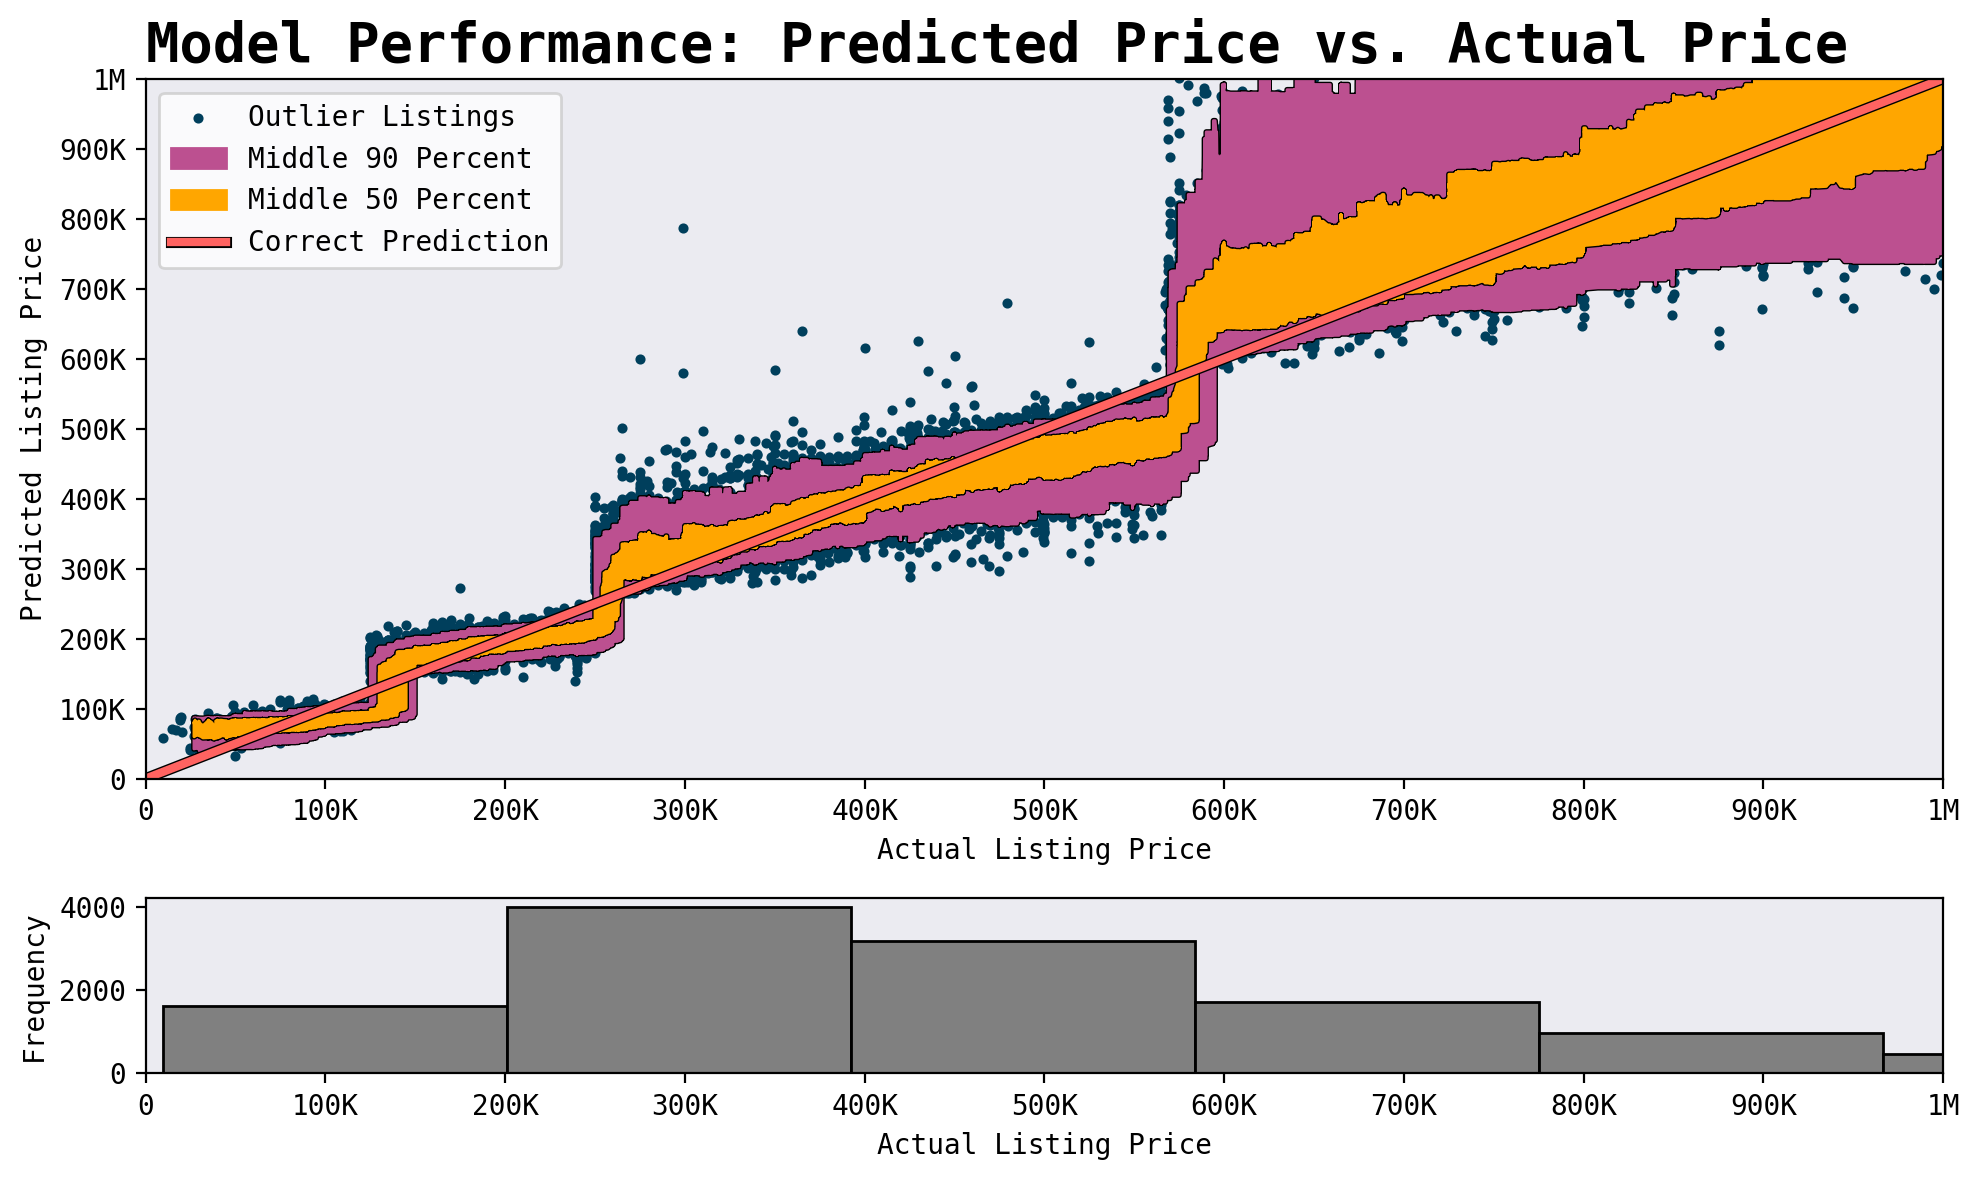

In [ ]:
# Plot errors.
plot_errors(y_test, y_pred)

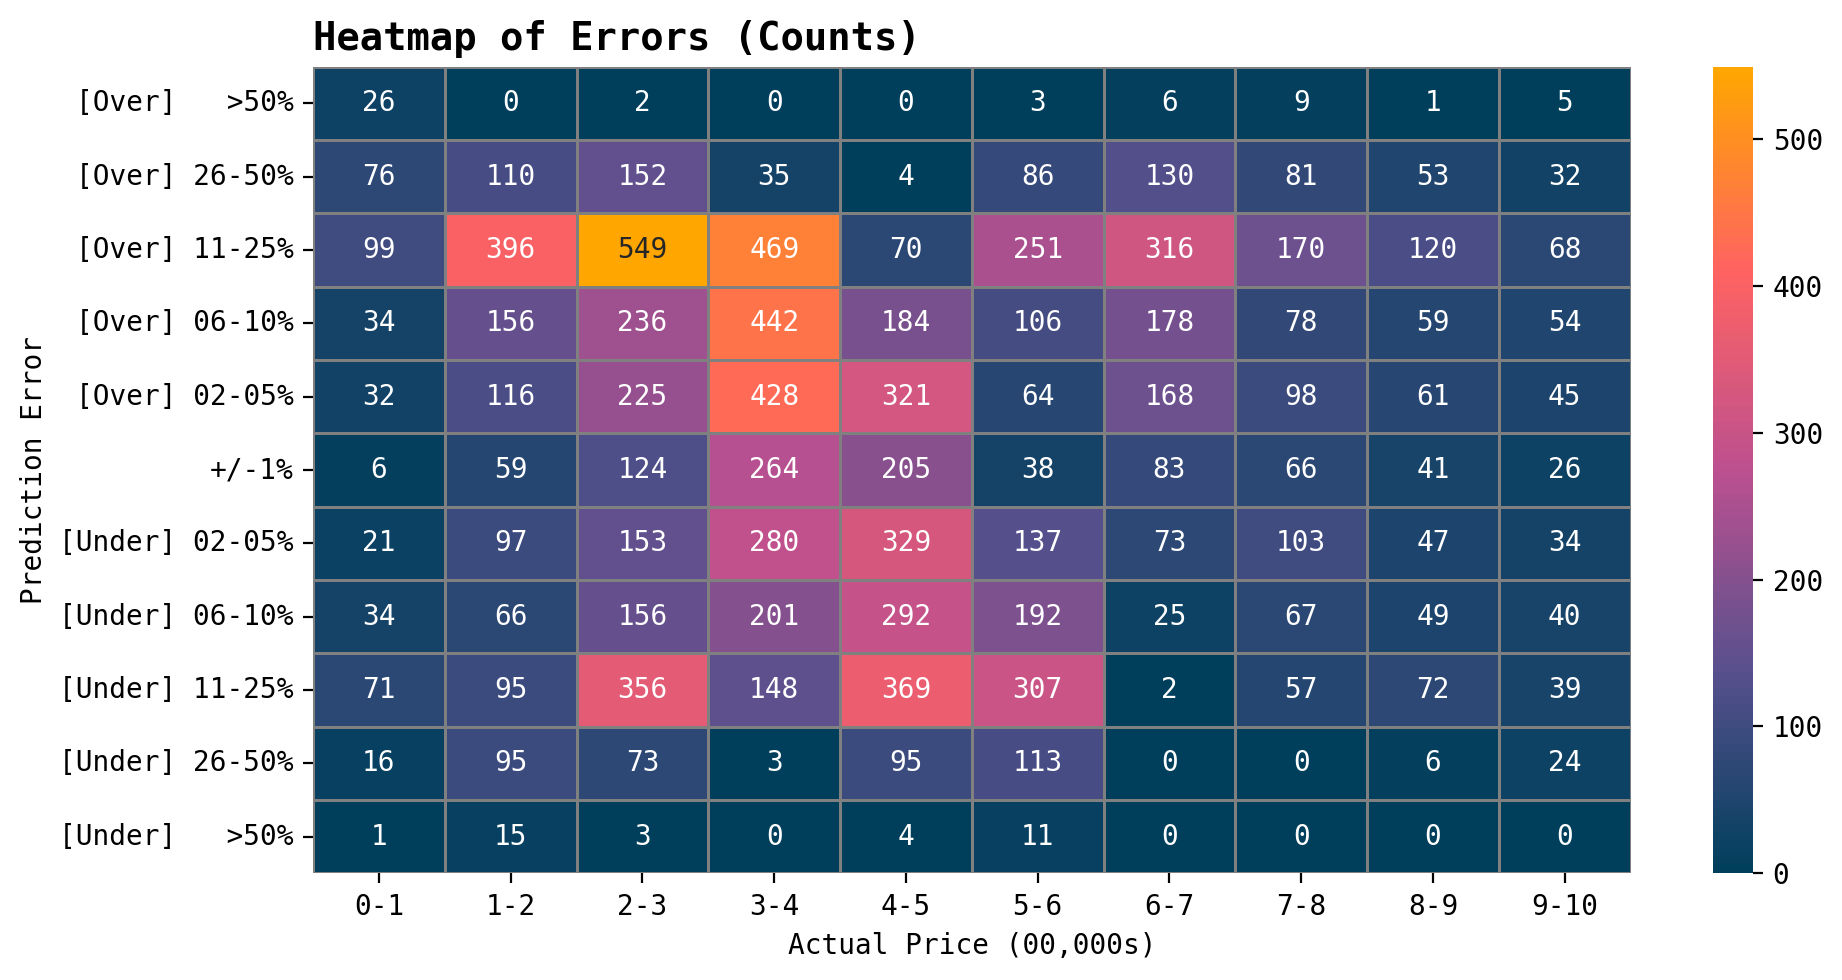

In [ ]:
# Plot heatmap.
plot_errors_heatmap(y_test, y_pred)

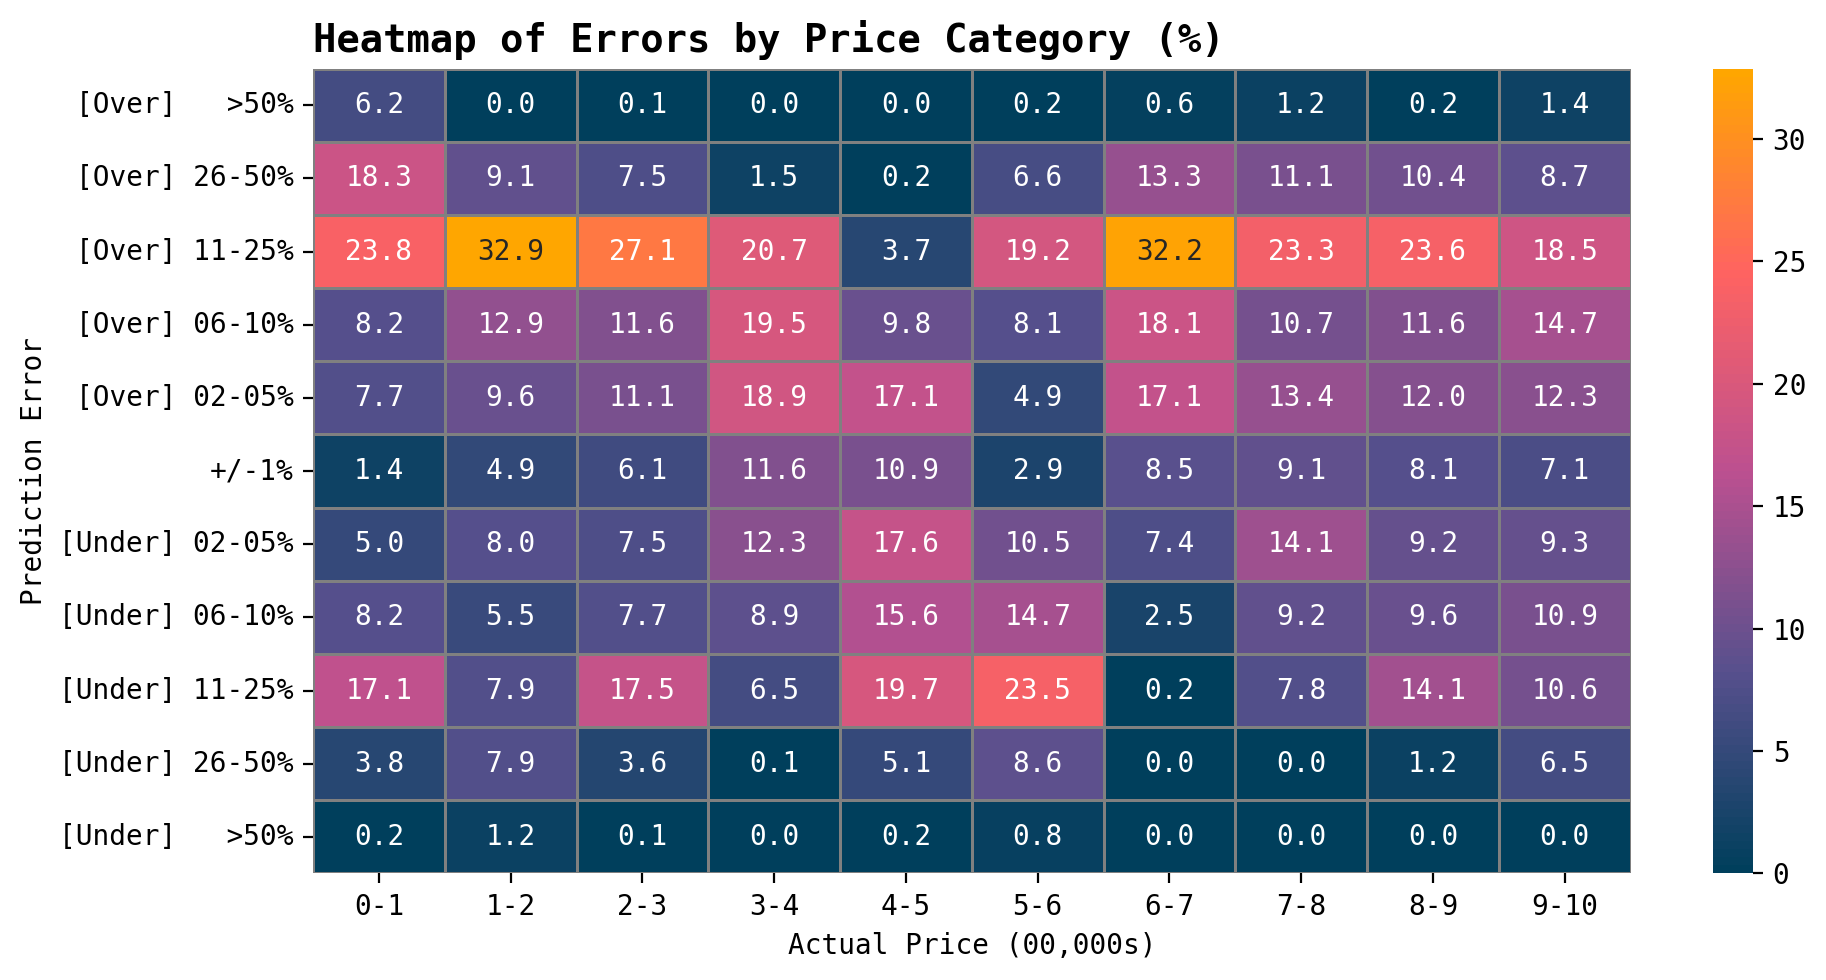

In [ ]:
# Plot heatmap (percentage).
plot_errors_heatmap(y_test, y_pred, pct=True)

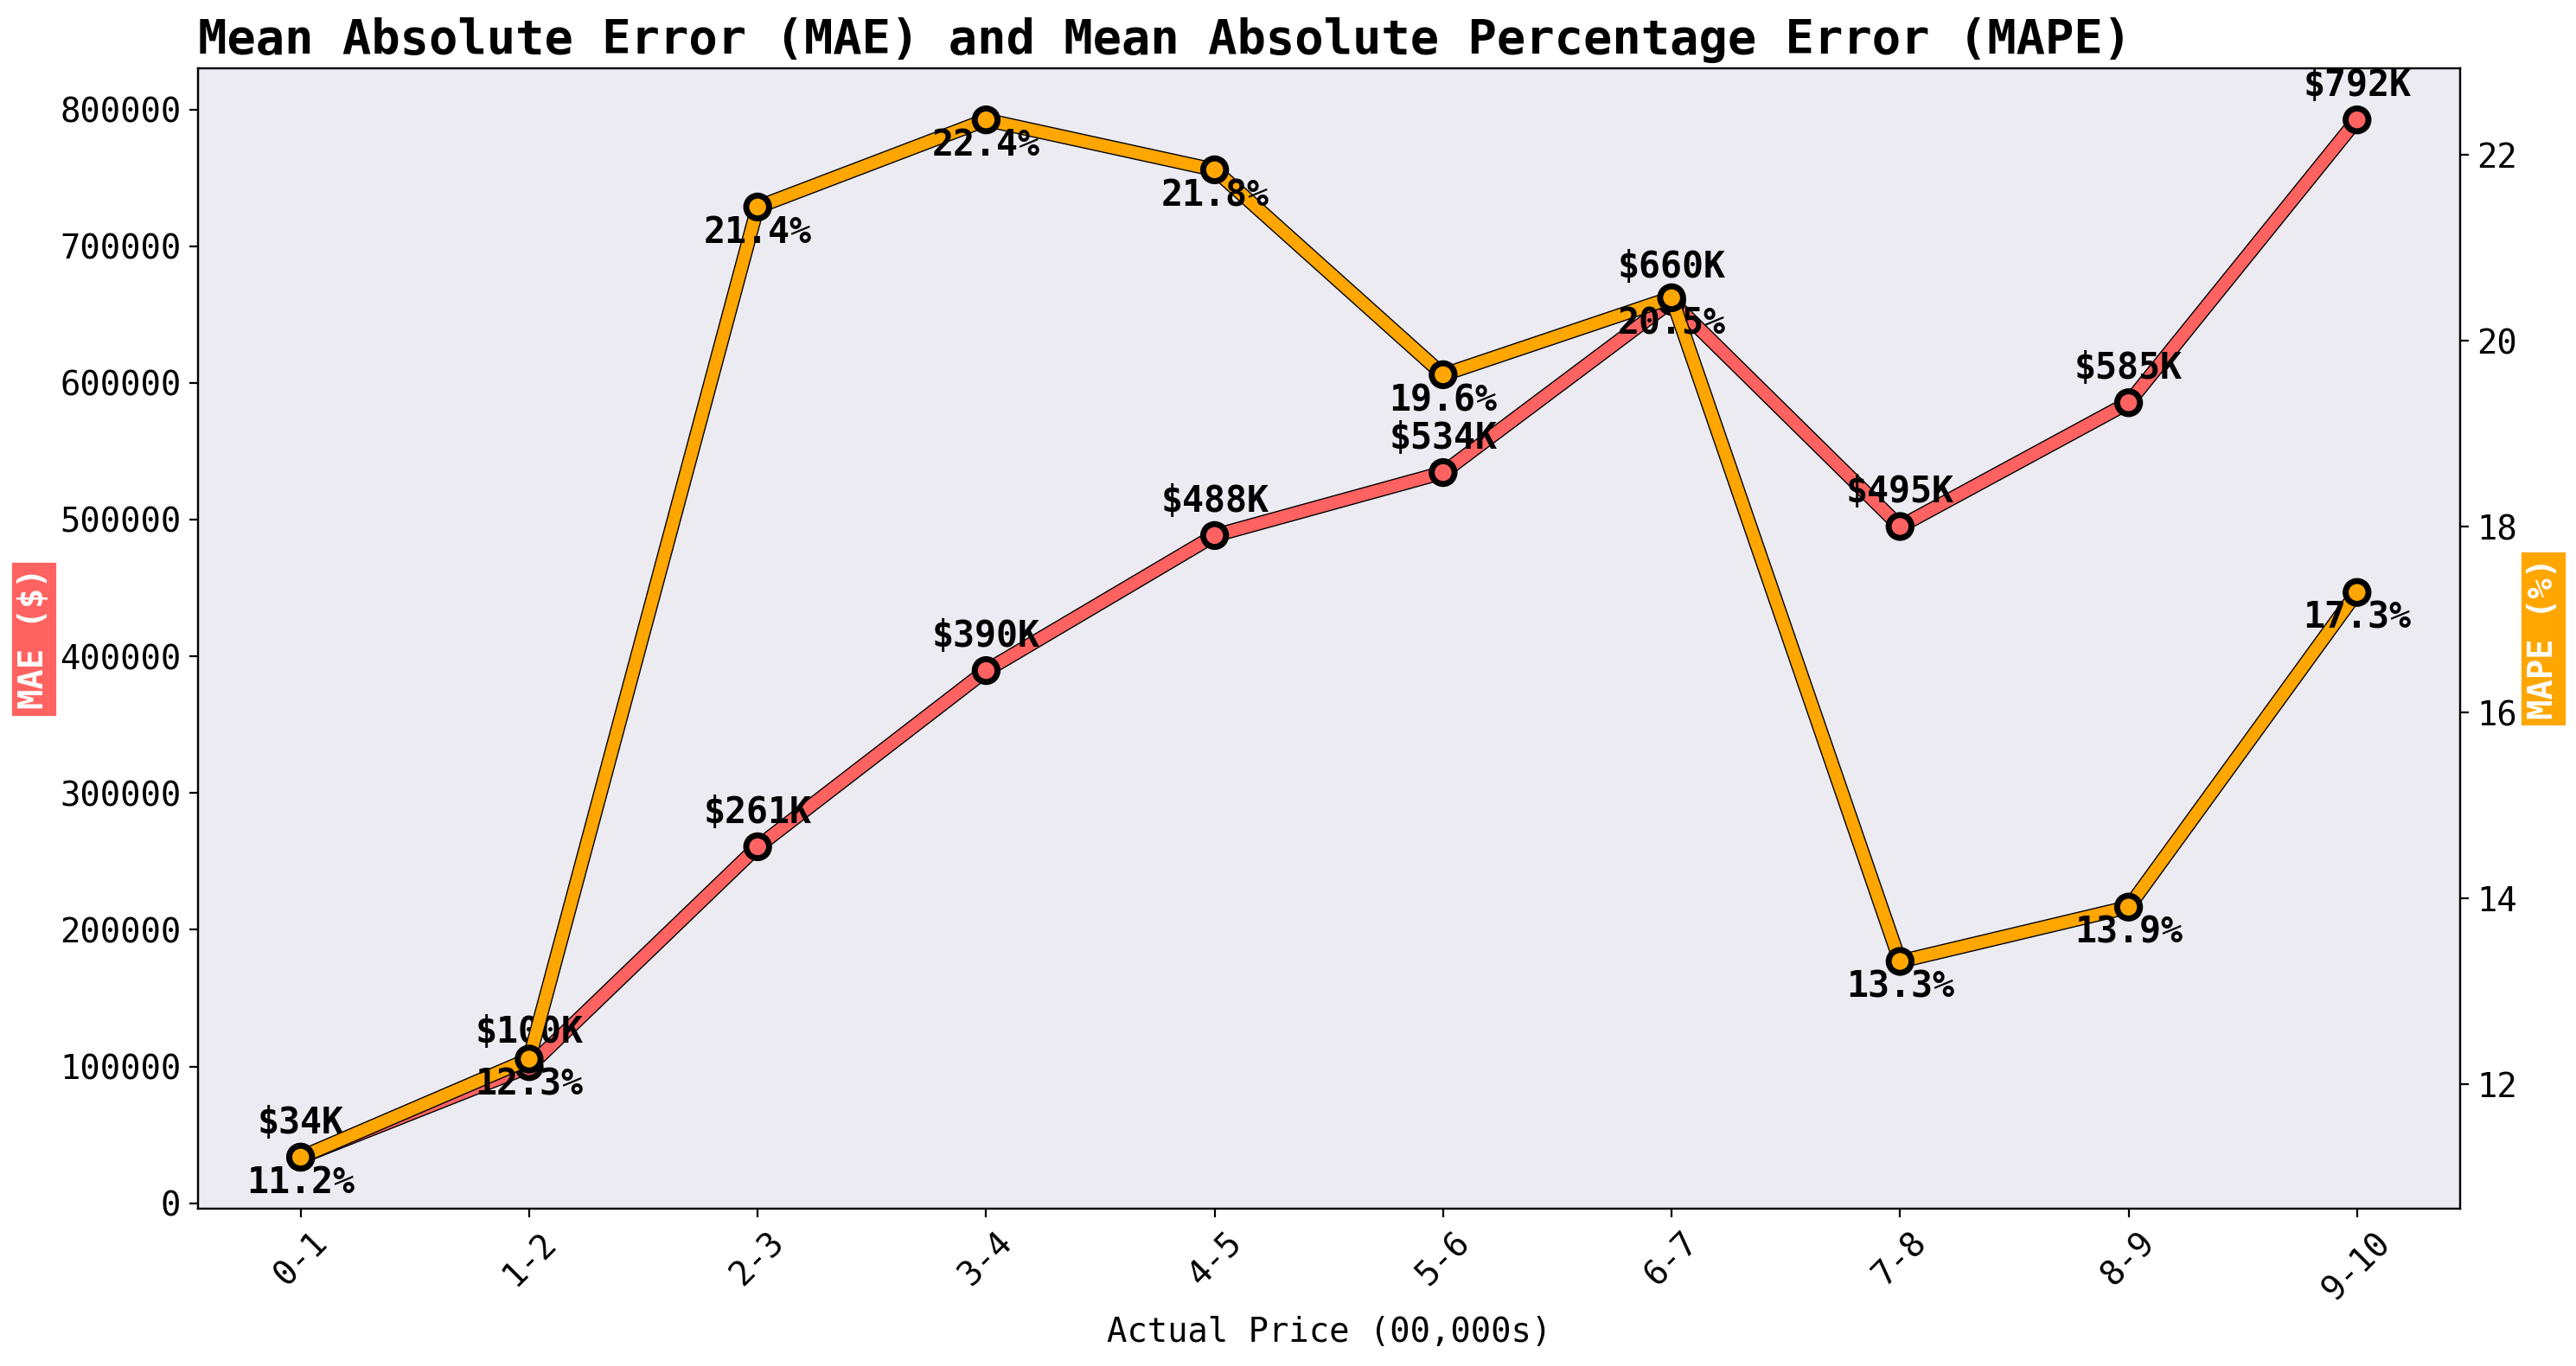

In [ ]:
# Plot mape / mae trade off.
plot_errors_mape_vs_mae(y_test, y_pred)

### v2

An expanded set of points of interest, including information about whether or not it is in a major city, close to a ocean, or near the mountains. It also includes a lot of risk data about severe weather and potential social and economic losses that might come from that.

In [ ]:
# V2 feature set.
featureSet2 = [
    "bedrooms", "bathrooms", "livingArea", "hasGarage", "parkingCapacity",
    "hasHeating", "fireplaces", "hasWaterfrontView", "isSeniorCommunity",
    "lotSize", "hoaFee", "buyersFeePerc", "daysOnZillow", "views", "favorites",
    "percSellFaster", "propertyTax", "mortgageRate", "agentRecentSales",
    "agentReviewsCount", "isForeclosure", "isBankOwned", "rentZestimate",
    "totalActualRent", "termsCash", "termsConventional", "termsFHA", "termsVA",
    "schoolAverageDistance", "schoolContainsCharter", "schoolRatingMiddleSchool",
    "schoolRatingHighSchool", "schoolRatingElementary", "hasPatioPorch",
    "national_park", "post_office", "tiny_museum", "small_museum", "medium_museum",
    "large_museum", "massive_museum", "top_trail", "hidden_gem_trail",
    "tougth_to_love_trail", "under_the_radar_trail", "prison", "clean_power_plant",
    "dirty_power_plant", "police_station", "most_serious_crimes_per_capita",
    "serious_crimes_per_capita", "less_serious_crimes_per_capita",
    "total_stolen_value_per_capita", "2022_county_pop", "homeType","sewer","City Tier",
    "close_atlantic","close_pacific","in_mountains","riskScore","expectedAnnualLossScore",
    "expectedAnnualLossTotal","socialVulnerabilityScore","resiliencyScore","avalancheAnnualizedFrequency",
    "coastalFloodingAnnualizedFrequency","coldWaveAnnualizedFrequency","droughtAnnualizedFrequency",
    "earthquakeAnnualizedFrequency","hailAnnualizedFrequency","heatWaveAnnualizedFrequency",
    "hurricanAnnualizedFrequency","iceStormAnnualizedFrequency","landslideAnnualizedFrequency",
    "lightningAnnualizedFrequency","riverineFloodingAnnualizedFrequency","strongWindAnnualizedFrequency",
    "tornadoAnnualizedFrequency","tsunamiAnnualizedFrequency","volcanicActivityAnnualizedFrequency",
    "wildFireAnnualizedActivity","winterWeatherAnnualizedFrequency","yearBuilt", "city", "state_x"
]

In [ ]:
# Evaluate the algorithms, save results.
v2_results = evaluate_algorithms(df, featureSet2, algorithms,filename=None)
v2_results.to_csv('v2_model_results.csv')

100%|██████████| 1/1 [03:37<00:00, 217.26s/it]


In [ ]:
# Visualize results.
v2_results[['model','rmse','r2','mae','mape']].sort_values(by='r2',ascending=False)

model           rmse        r2           mae      mape
0  Extra Trees Regressor  232239.462466  0.874398  96350.819342  0.136996

In [ ]:
# Unpack y_test / y_pred values from winning model.
y_test = pickle.loads(v2_results[v2_results['model']=='Extra Trees Regressor']['y_test'].values[0])
y_pred = pickle.loads(v2_results[v2_results['model']=='Extra Trees Regressor']['y_pred'].values[0])

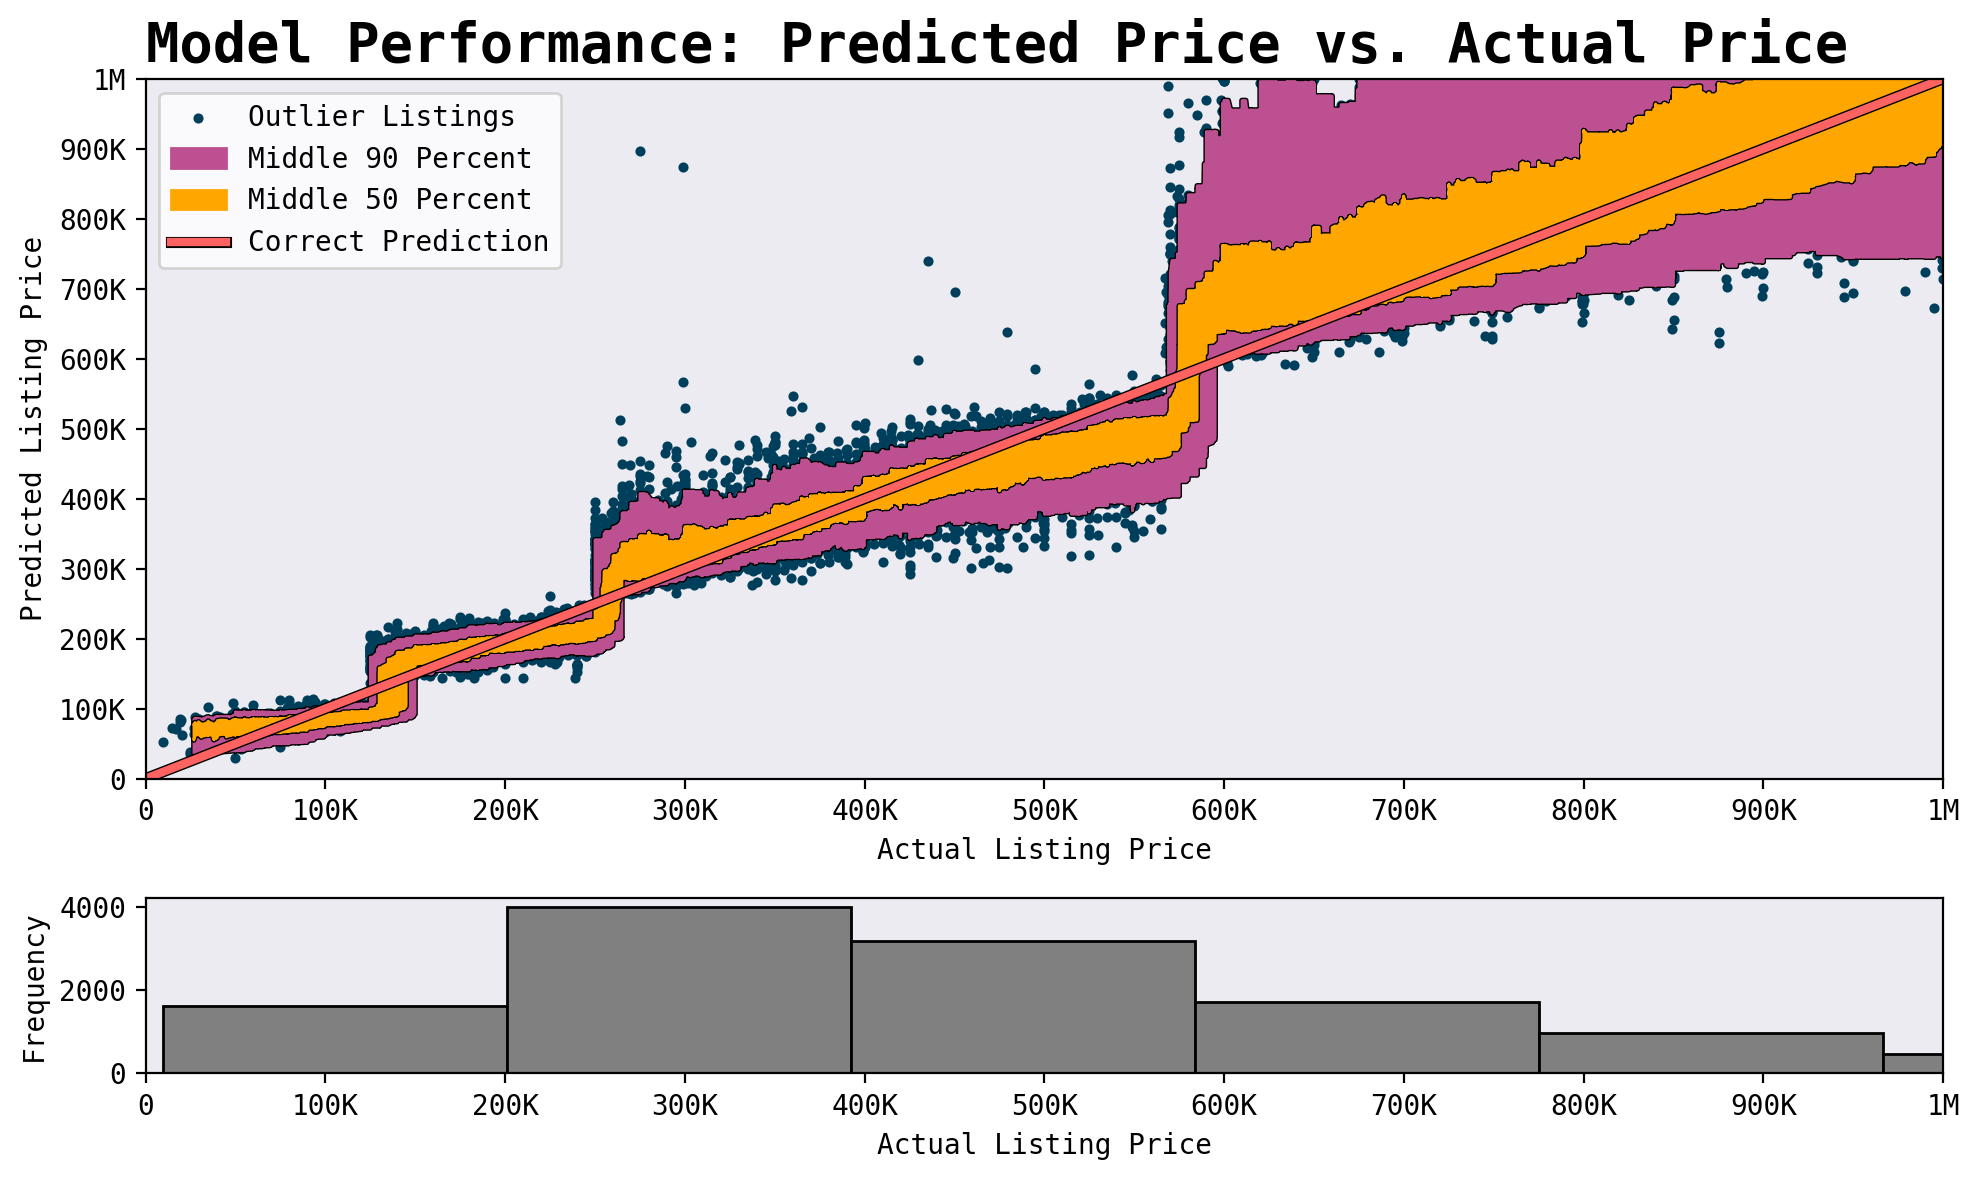

In [ ]:
# Plot errors.
plot_errors(y_test, y_pred)

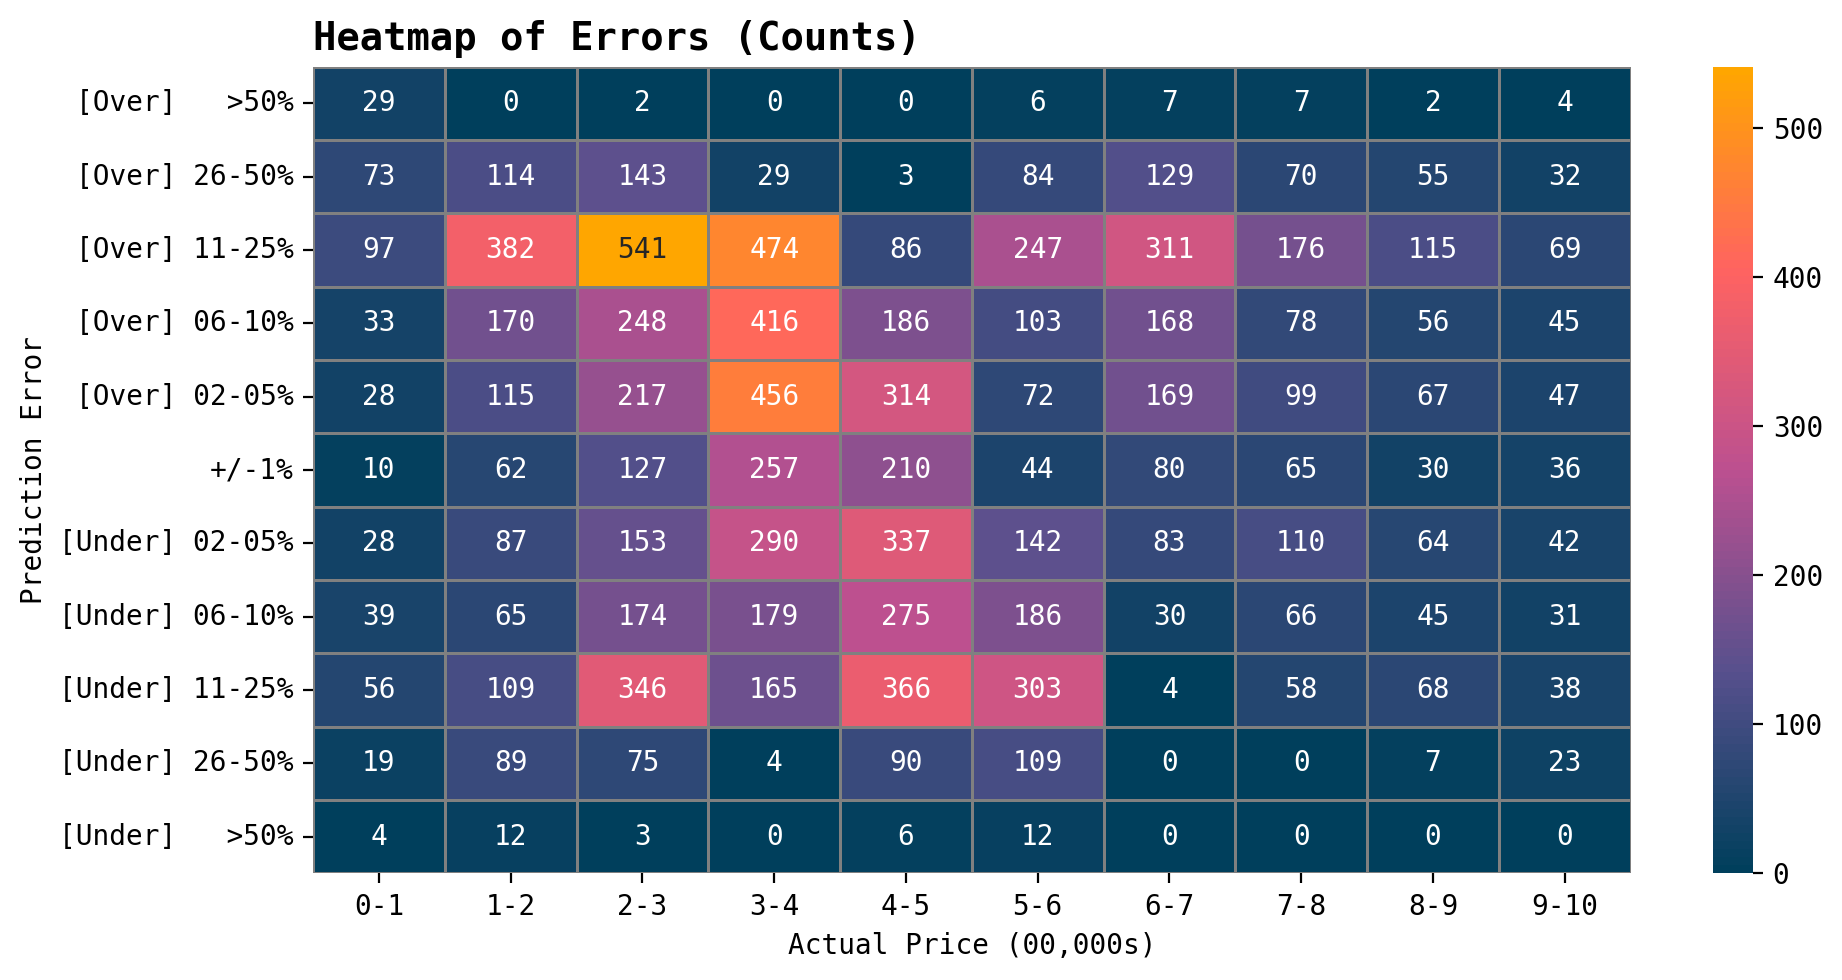

In [ ]:
# Plot heatmap.
plot_errors_heatmap(y_test, y_pred)

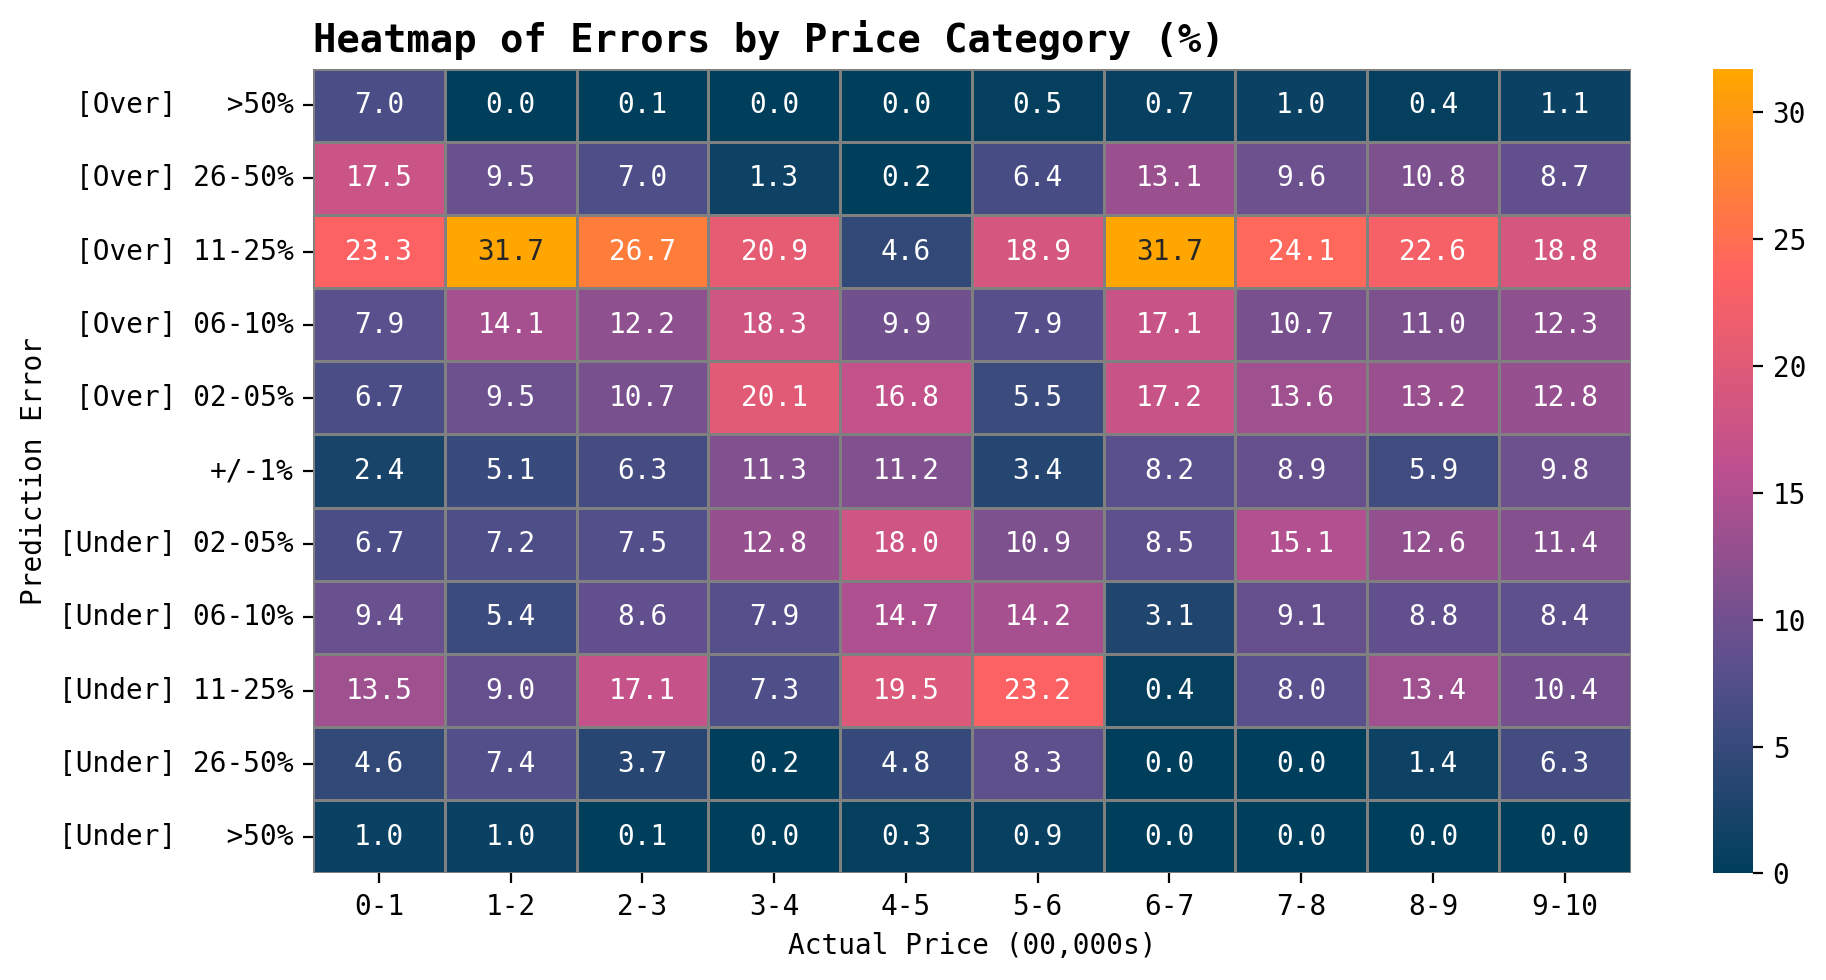

In [ ]:
# Plot heatmap (percentage).
plot_errors_heatmap(y_test, y_pred, pct=True)

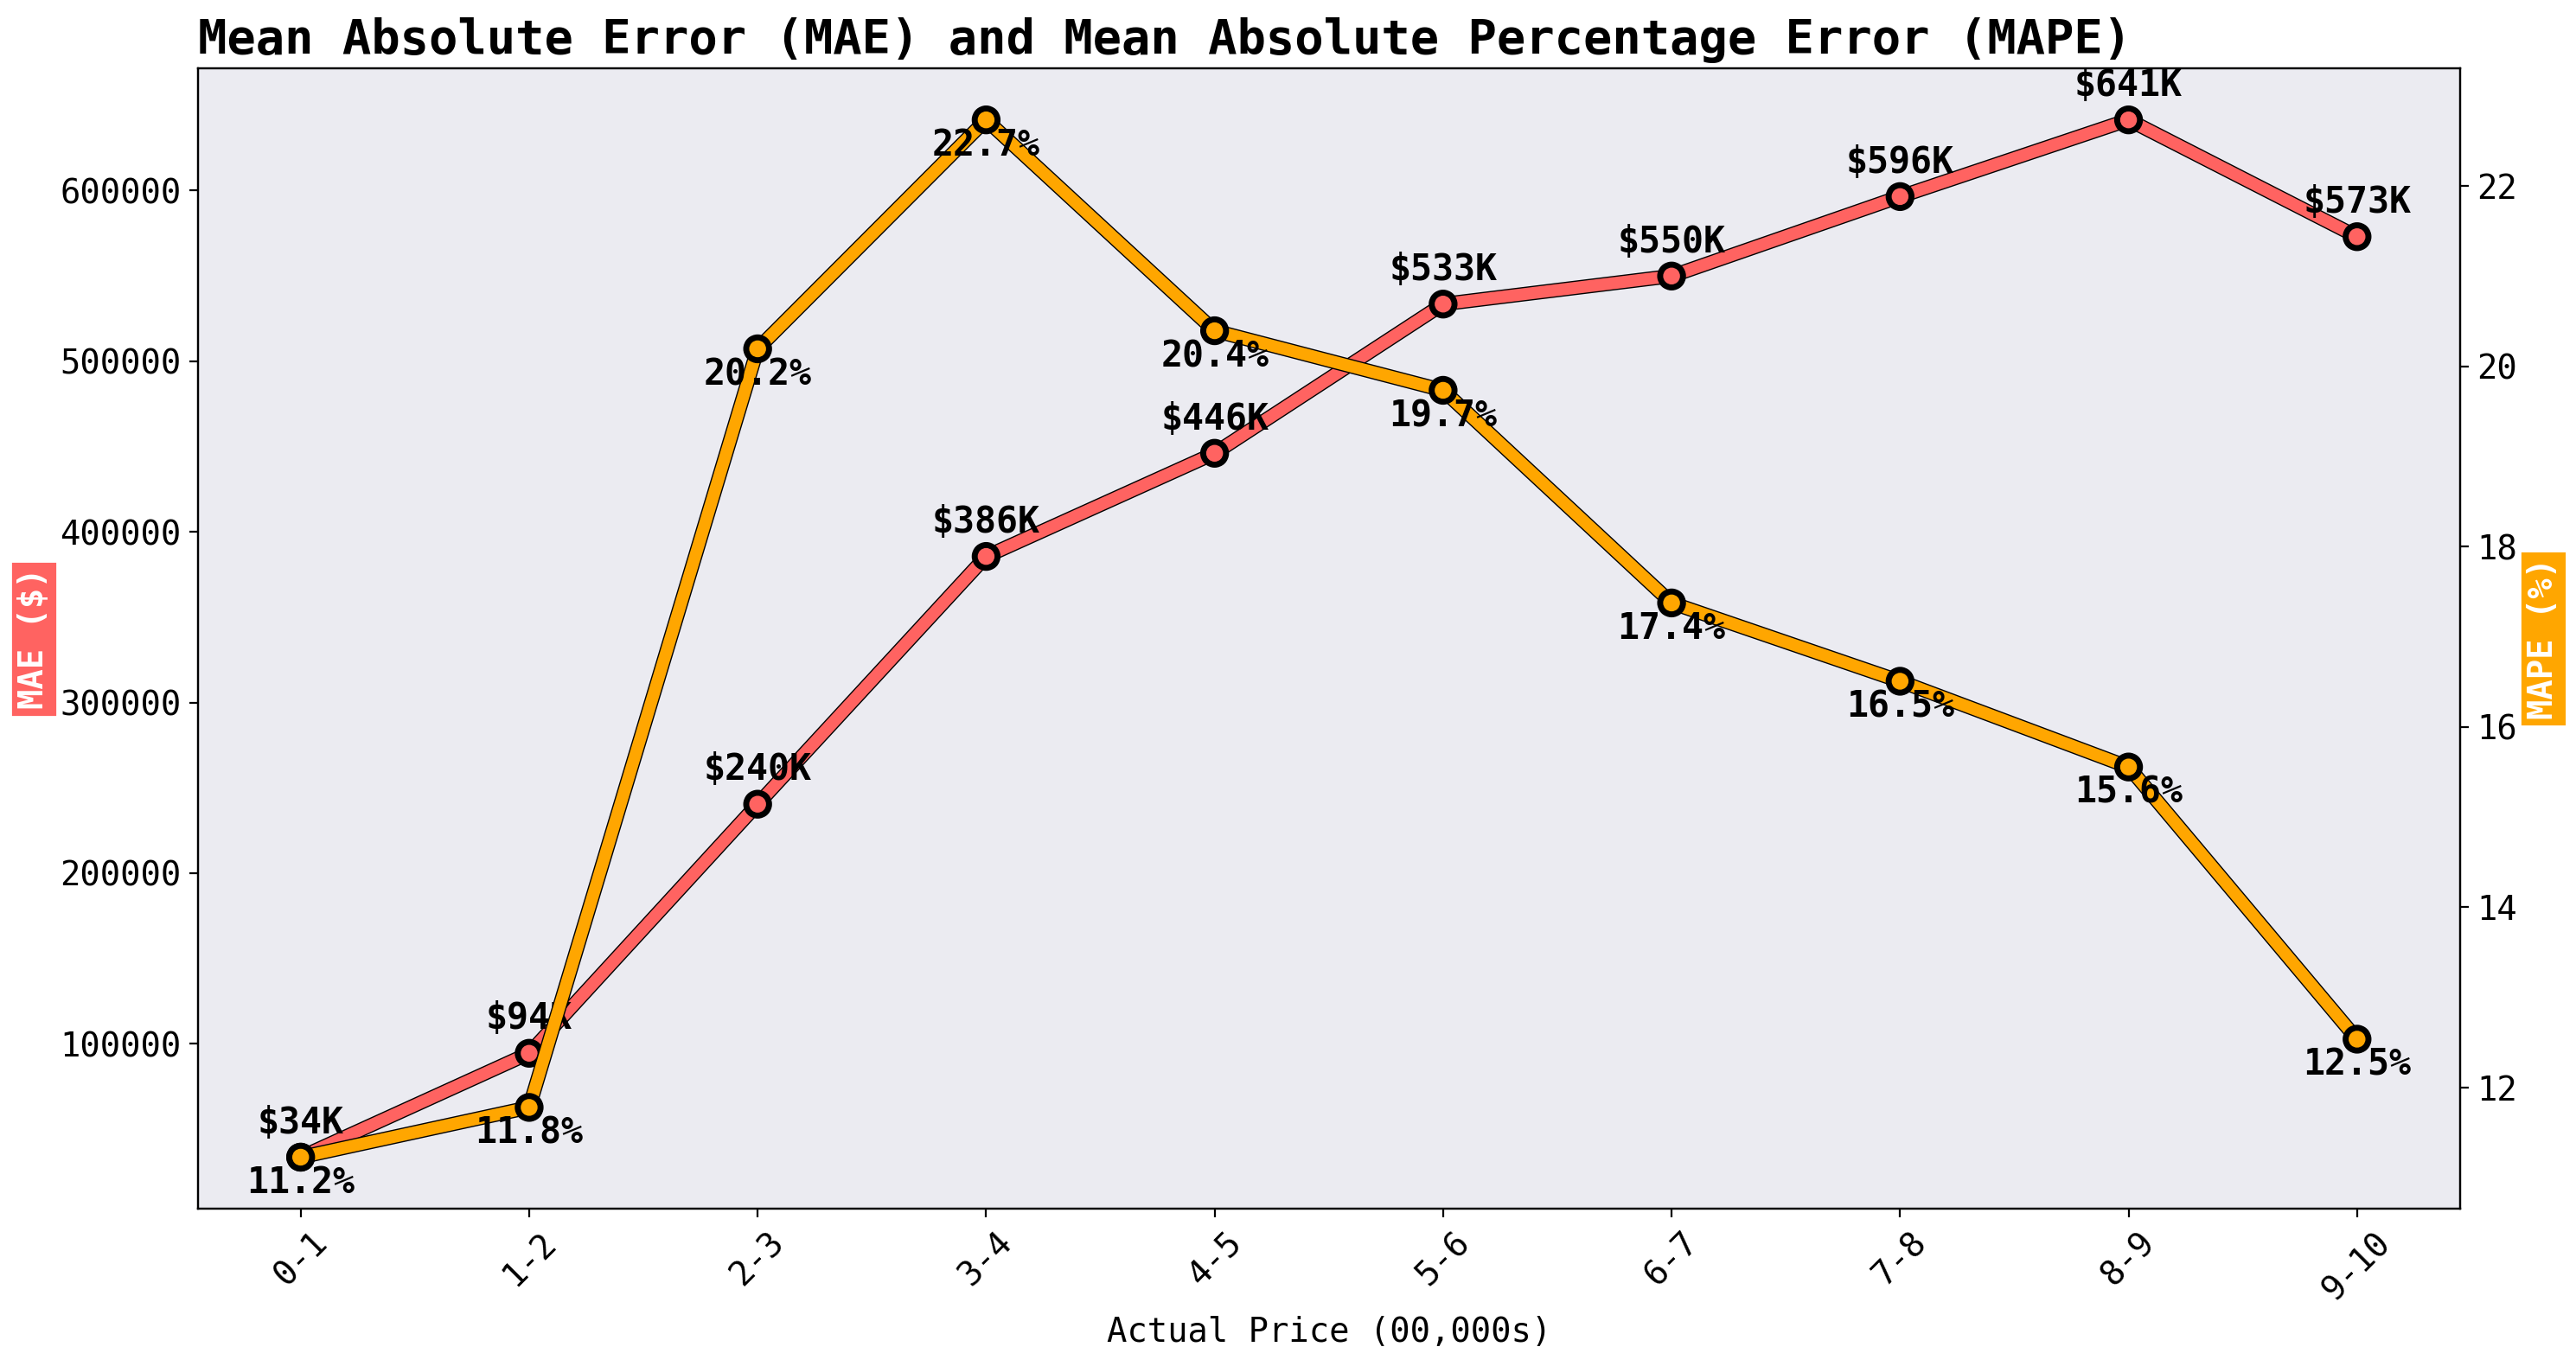

In [ ]:
# Plot mae / mape trade off.
plot_errors_mape_vs_mae(y_test, y_pred)

# v3

In this next one, I'm going to add a single varibale -- comps. I think this has a chance of being a high value predictor in bringing more data about the home's expected price.

Comps is the average price of the 5 most similar nearby homes that are also on the market.

In [ ]:
#V3 feature set.
featureSet3 = [
    "bedrooms", "bathrooms", "livingArea", "hasGarage", "parkingCapacity",
    "hasHeating", "fireplaces", "hasWaterfrontView", "isSeniorCommunity",
    "lotSize", "hoaFee", "buyersFeePerc", "daysOnZillow", "views", "favorites",
    "percSellFaster", "propertyTax", "mortgageRate", "agentRecentSales",
    "agentReviewsCount", "isForeclosure", "isBankOwned", "rentZestimate",
    "totalActualRent", "termsCash", "termsConventional", "termsFHA", "termsVA",
    "schoolAverageDistance", "schoolContainsCharter", "schoolRatingMiddleSchool",
    "schoolRatingHighSchool", "schoolRatingElementary", "hasPatioPorch",
    "national_park", "post_office", "tiny_museum", "small_museum", "medium_museum",
    "large_museum", "massive_museum", "top_trail", "hidden_gem_trail",
    "tougth_to_love_trail", "under_the_radar_trail", "prison", "clean_power_plant",
    "dirty_power_plant", "police_station", "most_serious_crimes_per_capita",
    "serious_crimes_per_capita", "less_serious_crimes_per_capita",
    "total_stolen_value_per_capita", "2022_county_pop", "homeType","sewer","City Tier",
    "close_atlantic","close_pacific","in_mountains","riskScore","expectedAnnualLossScore",
    "expectedAnnualLossTotal","socialVulnerabilityScore","resiliencyScore","avalancheAnnualizedFrequency",
    "coastalFloodingAnnualizedFrequency","coldWaveAnnualizedFrequency","droughtAnnualizedFrequency",
    "earthquakeAnnualizedFrequency","hailAnnualizedFrequency","heatWaveAnnualizedFrequency",
    "hurricanAnnualizedFrequency","iceStormAnnualizedFrequency","landslideAnnualizedFrequency",
    "lightningAnnualizedFrequency","riverineFloodingAnnualizedFrequency","strongWindAnnualizedFrequency",
    "tornadoAnnualizedFrequency","tsunamiAnnualizedFrequency","volcanicActivityAnnualizedFrequency",
    "wildFireAnnualizedActivity","winterWeatherAnnualizedFrequency","comps","yearBuilt", "city", "state_x"
]

In [ ]:
# Evaluate the algorithms, save the results.
v3_results = evaluate_algorithms(df, featureSet3, algorithms,filename=None)
v3_results.to_csv('v3_model_results.csv')

100%|██████████| 1/1 [03:49<00:00, 229.11s/it]


In [ ]:
# Visualize results.
v3_results[['model','rmse','r2','mae','mape']].sort_values(by='r2',ascending=False)

model           rmse        r2           mae      mape
0  Extra Trees Regressor  222065.209813  0.885162  93431.731189  0.132715

In [ ]:
# Unpack y_test / y_pred values from winning model.
y_test = pickle.loads(v3_results[v3_results['model']=='Extra Trees Regressor']['y_test'].values[0])
y_pred = pickle.loads(v3_results[v3_results['model']=='Extra Trees Regressor']['y_pred'].values[0])

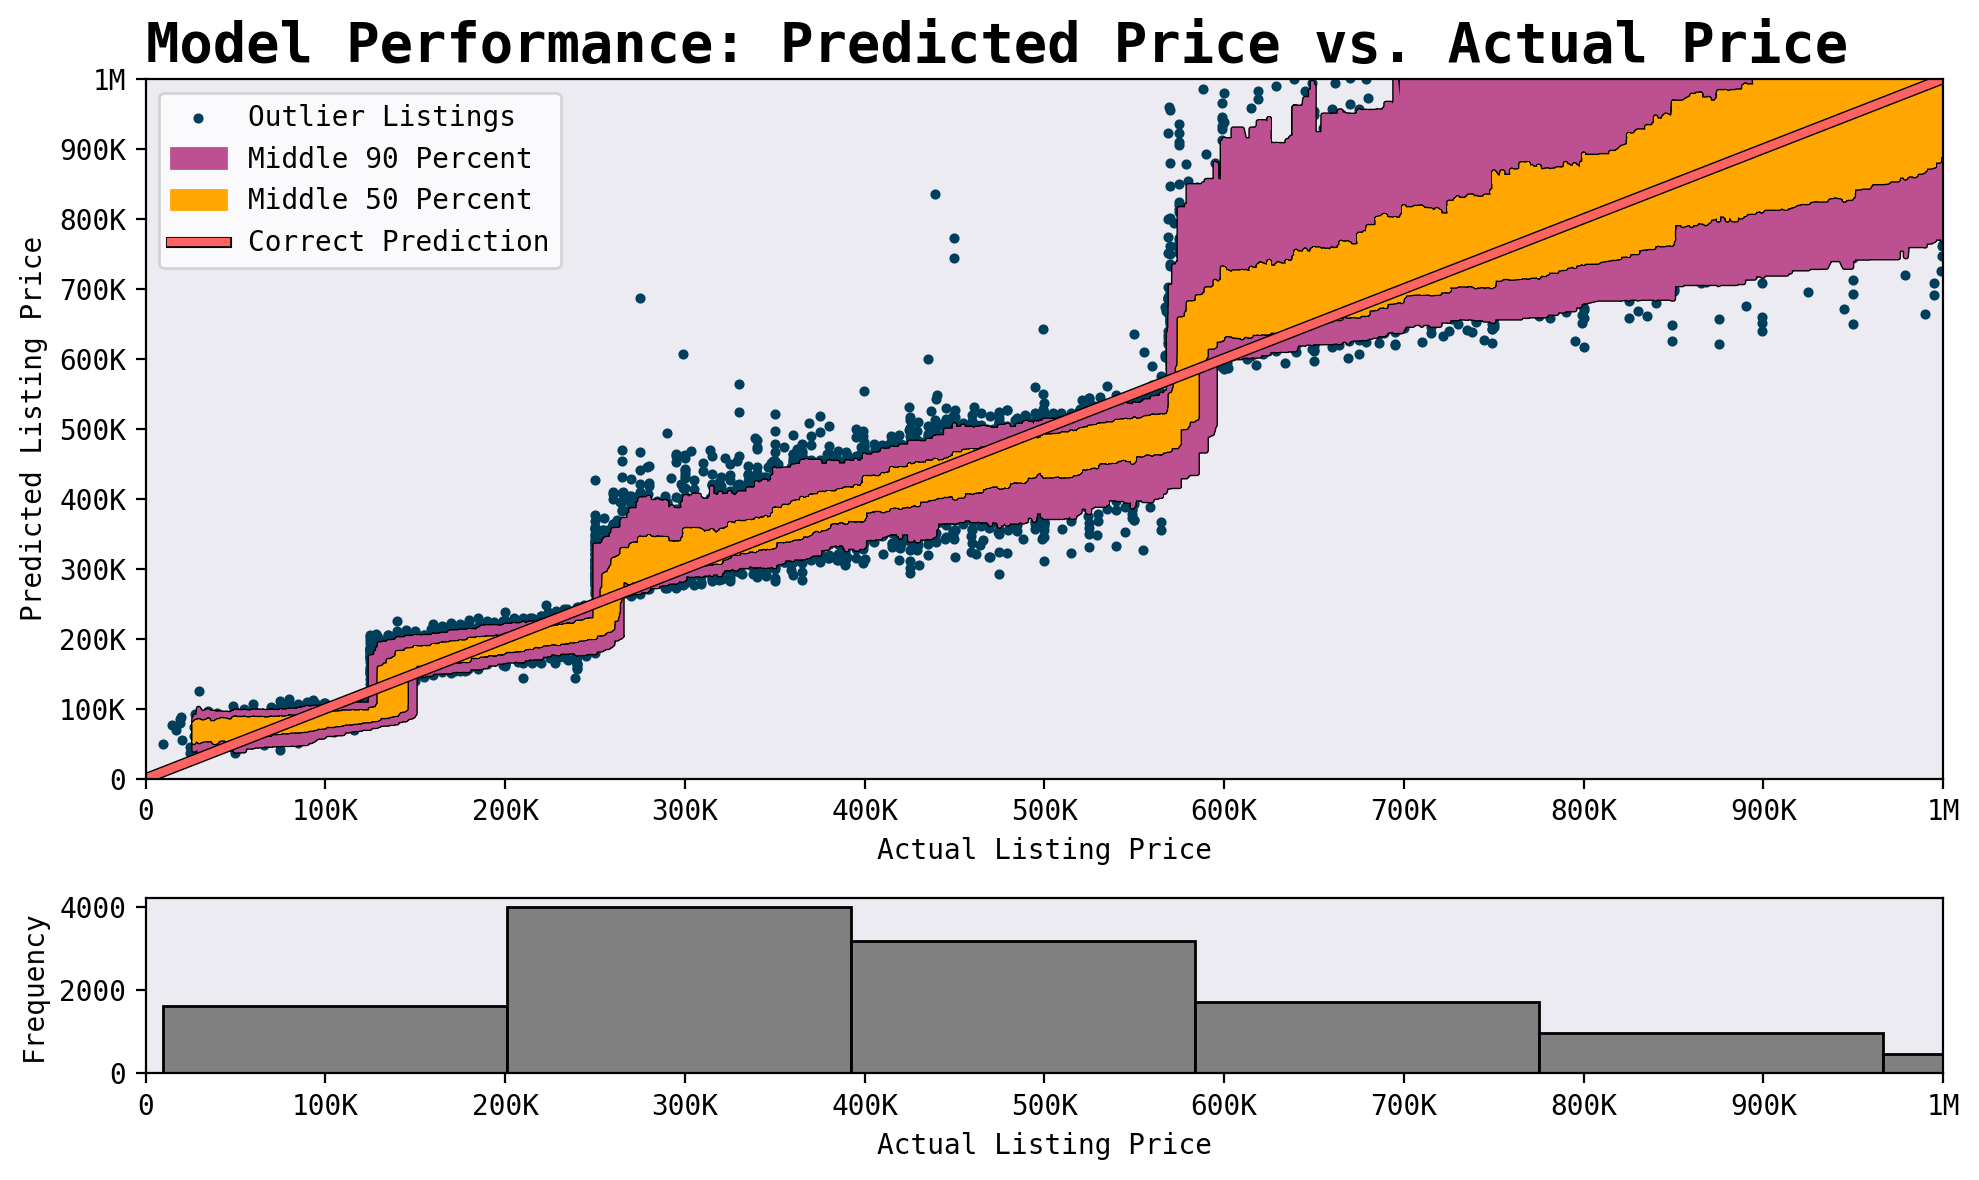

In [ ]:
# Plot errors.
plot_errors(y_test, y_pred)

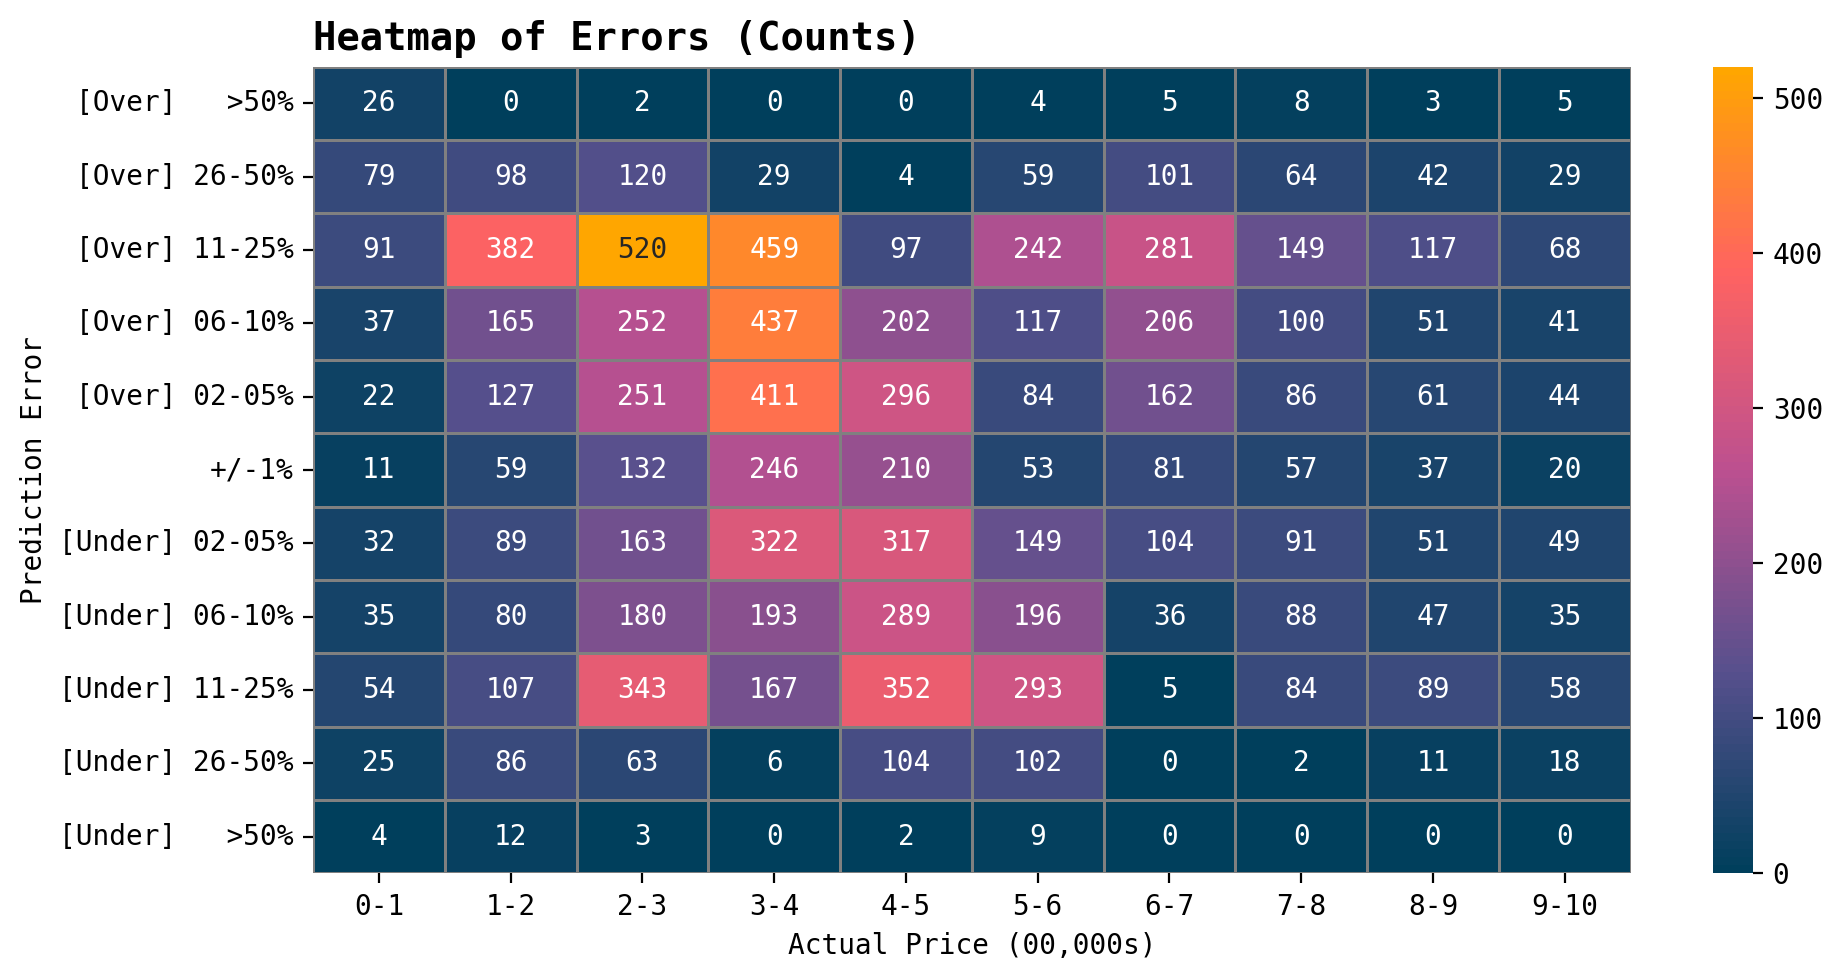

In [ ]:
# Plot heatmap.
plot_errors_heatmap(y_test, y_pred)

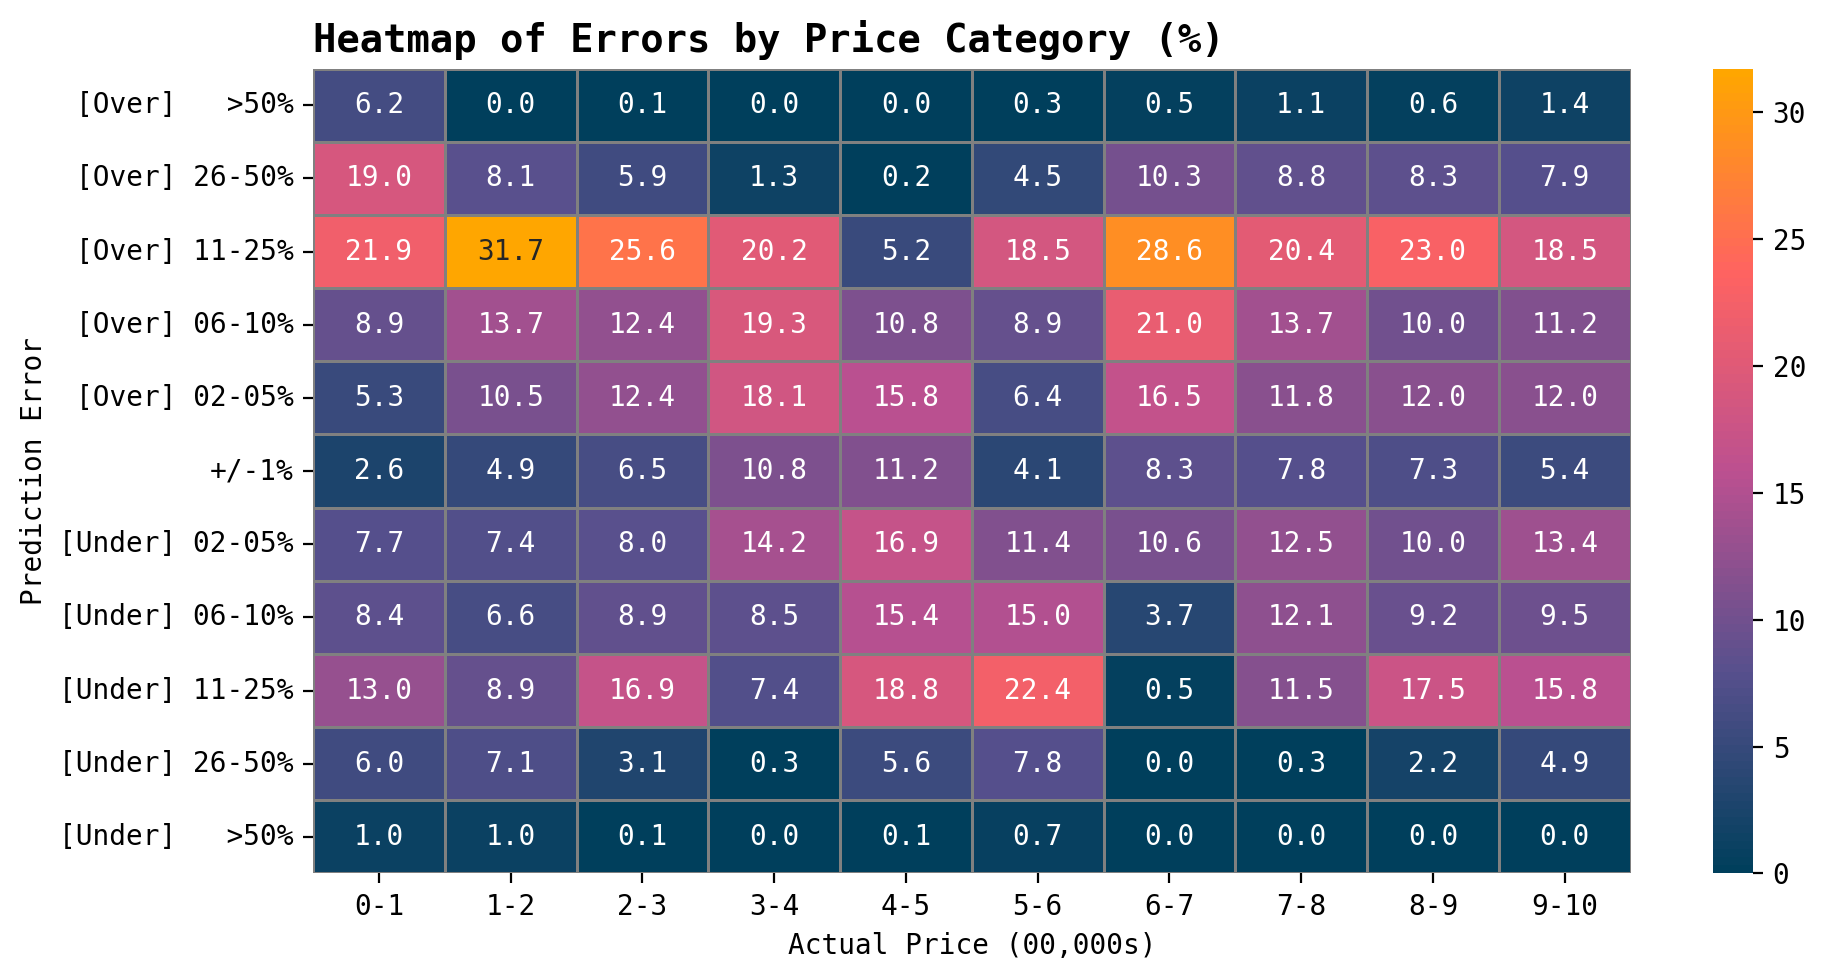

In [ ]:
# Plot heatmap (percentage).
plot_errors_heatmap(y_test, y_pred, pct=True)

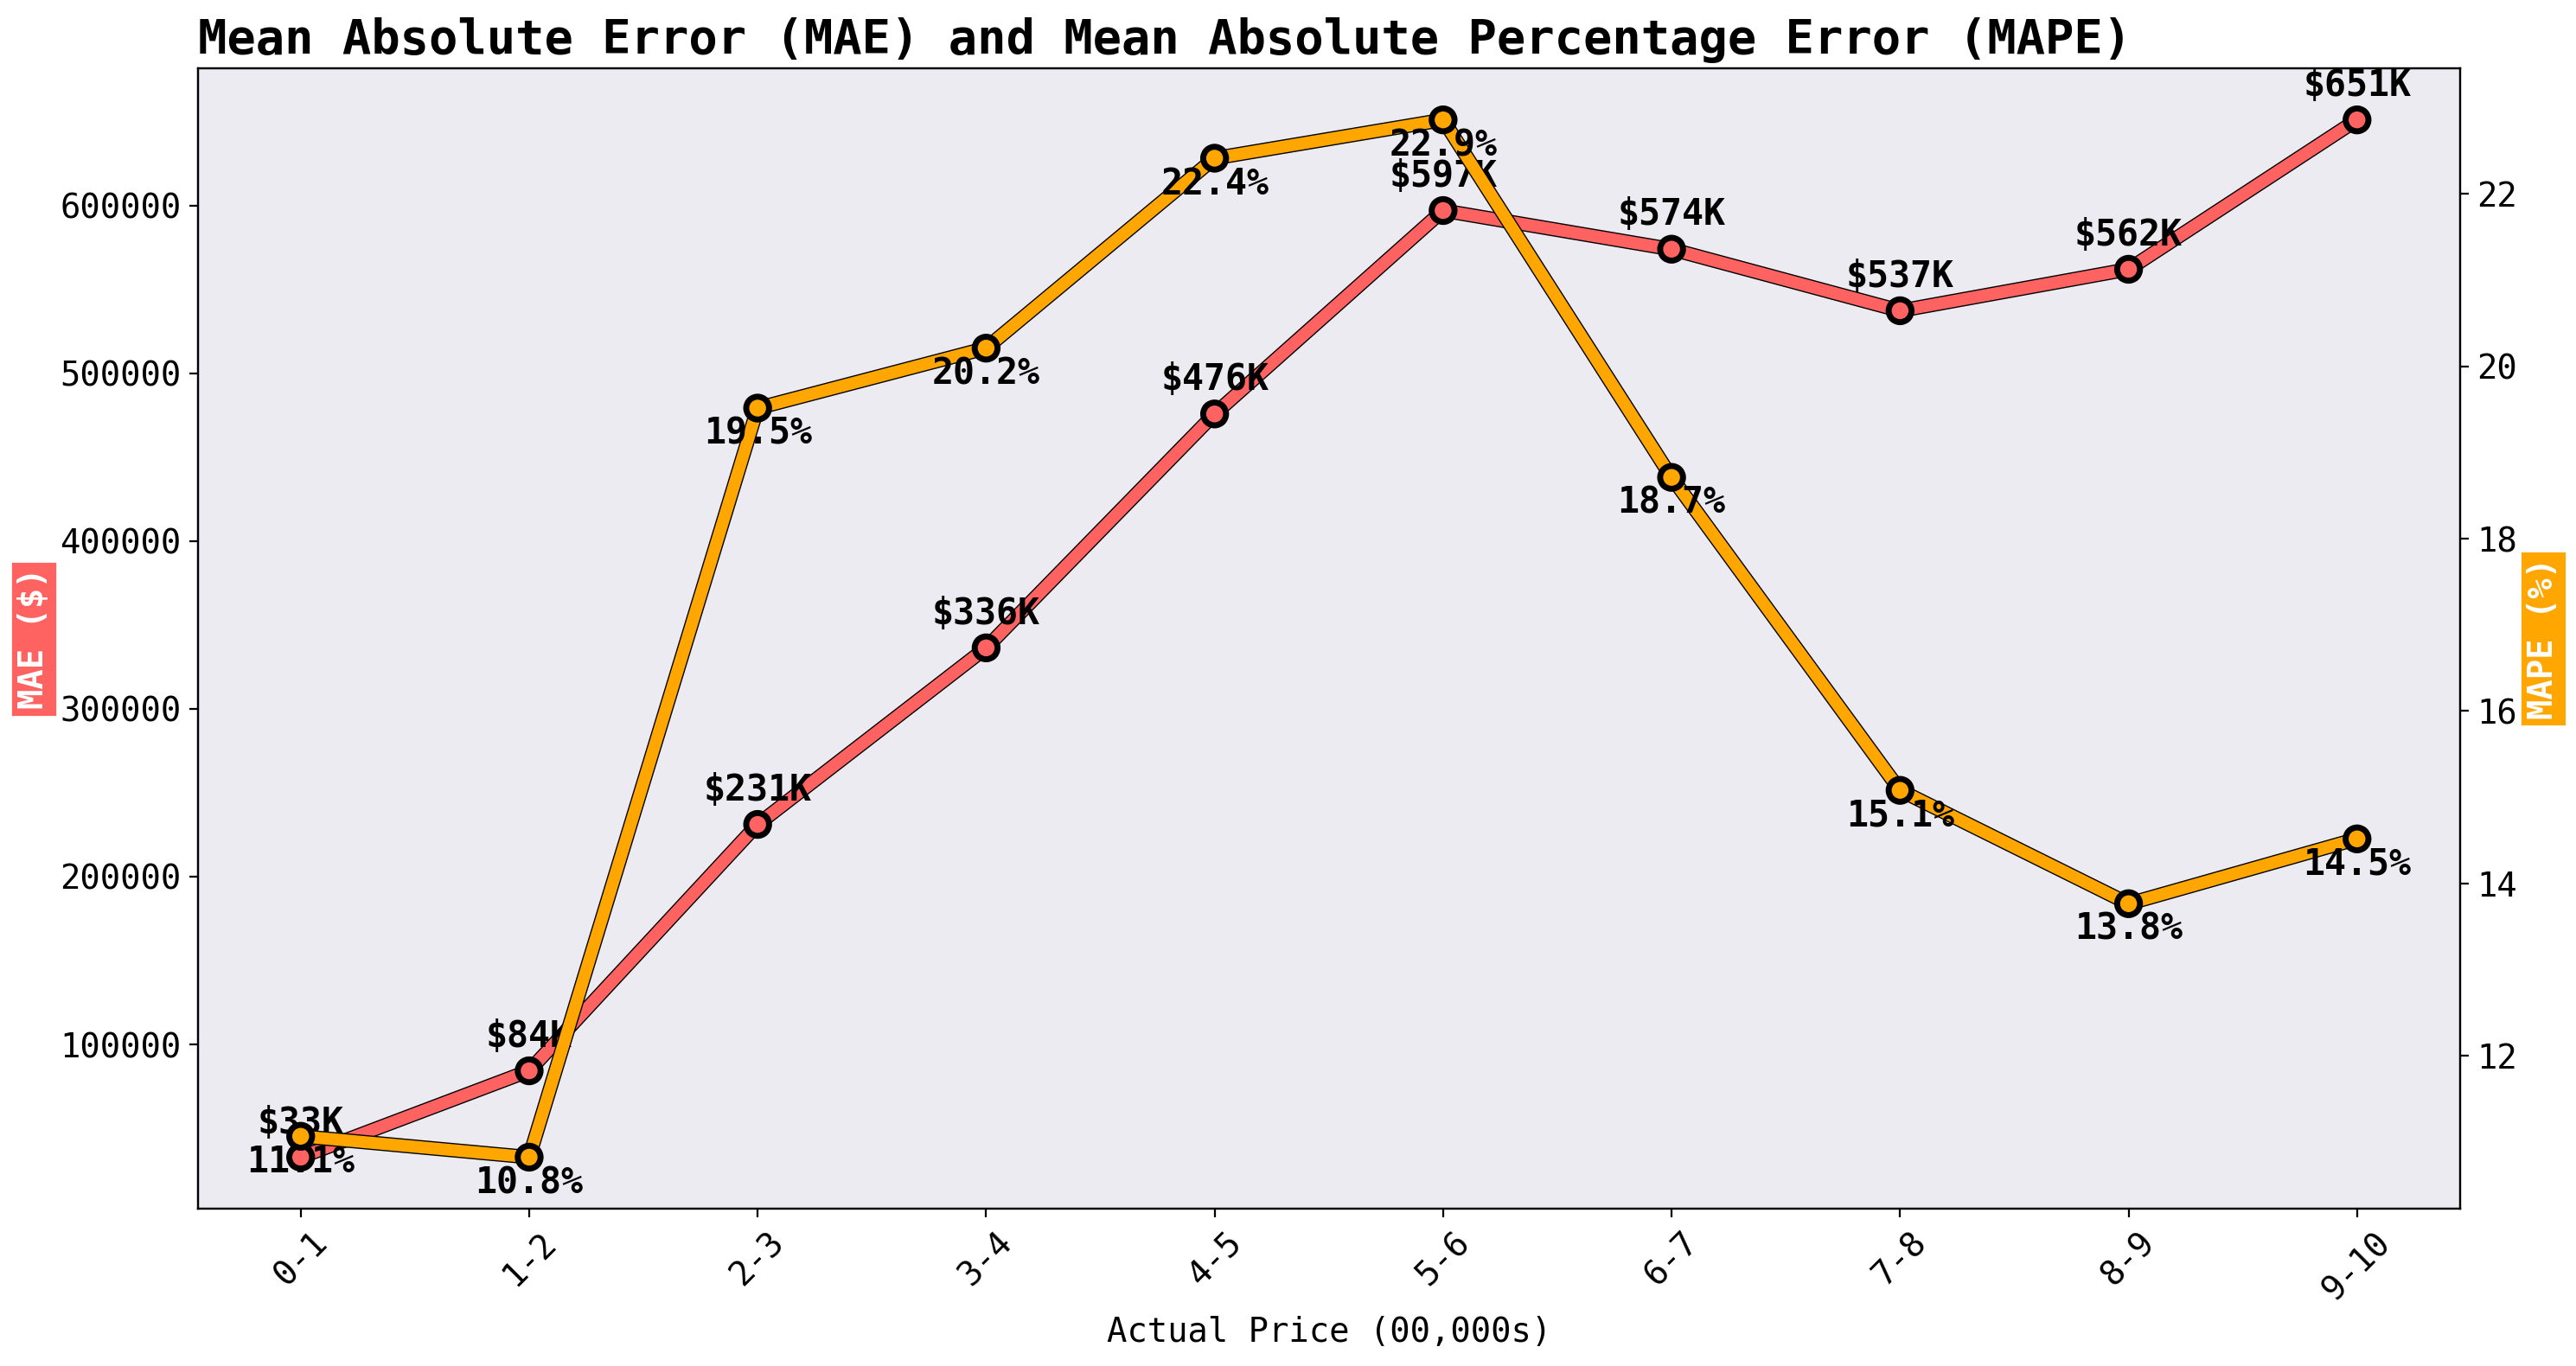

In [ ]:
# Plot mae / mape trade off.
plot_errors_mape_vs_mae(y_test, y_pred, bins=10)

In [ ]:
#V4 feature set.
featureSet4 = [
    "bedrooms", "bathrooms", "livingArea", "hasGarage", "parkingCapacity",
    "hasHeating", "fireplaces", "hasWaterfrontView", "isSeniorCommunity",
    "lotSize", "hoaFee", "buyersFeePerc", "daysOnZillow", "views", "favorites",
    "percSellFaster", "propertyTax", "mortgageRate", "agentRecentSales",
    "agentReviewsCount", "isForeclosure", "isBankOwned", "rentZestimate",
    "totalActualRent", "termsCash", "termsConventional", "termsFHA", "termsVA",
    "schoolAverageDistance", "schoolContainsCharter", "schoolRatingMiddleSchool",
    "schoolRatingHighSchool", "schoolRatingElementary", "hasPatioPorch",
    "national_park", "post_office", "tiny_museum", "small_museum", "medium_museum",
    "large_museum", "massive_museum", "top_trail", "hidden_gem_trail",
    "tougth_to_love_trail", "under_the_radar_trail", "prison", "clean_power_plant",
    "dirty_power_plant", "police_station", "most_serious_crimes_per_capita",
    "serious_crimes_per_capita", "less_serious_crimes_per_capita",
    "total_stolen_value_per_capita", "2022_county_pop", "homeType","sewer","City Tier",
    "close_atlantic","close_pacific","in_mountains","riskScore","expectedAnnualLossScore",
    "expectedAnnualLossTotal","socialVulnerabilityScore","resiliencyScore","avalancheAnnualizedFrequency",
    "coastalFloodingAnnualizedFrequency","coldWaveAnnualizedFrequency","droughtAnnualizedFrequency",
    "earthquakeAnnualizedFrequency","hailAnnualizedFrequency","heatWaveAnnualizedFrequency",
    "hurricanAnnualizedFrequency","iceStormAnnualizedFrequency","landslideAnnualizedFrequency",
    "lightningAnnualizedFrequency","riverineFloodingAnnualizedFrequency","strongWindAnnualizedFrequency",
    "tornadoAnnualizedFrequency","tsunamiAnnualizedFrequency","volcanicActivityAnnualizedFrequency",
    "wildFireAnnualizedActivity","winterWeatherAnnualizedFrequency","comps",
    "ngram_dolean","ngram_options vast endless","ngram_possibilities","ngram_community design exclusive",
    "ngram_estate","ngram_stewarded","ngram_lucite","ngram_arclinea","ngram_marble block kitchen",
    "ngram_downtown ocean best","ngram_brand arclinea entertainers","ngram_bathrooms magnificient guest",
    "ngram_macassar","ngram_wine","ngram_masterpiece","ngram_private","ngram_cellar","ngram_infinity",
    "ngram_expansive","ngram_intracoastalview","ngram_designed","ngram_chefs","ngram_parties grand",
    "ngram_court tennis house","ngram_regencystyle","ngram_art deco gates","ngram_imposing main house",
    "ngram_mansions dotting nearby","ngram_luxury","ngram_unparalleled","ngram_marble","ngram_architect",
    "ngram_theater","ngram_outside scenery","ngram_staff","ngram_massage room","ngram_custom","ngram_magnificent",
    "ngram_extraordinary","ngram_privately owned island","ngram_gourmet","ngram_iconic","ngram_stunning",
    "ngram_infinityedge","ngram_panoramic","ngram_unobstructued sunrise sunset","ngram_aged white",
    "ngram_experience perfect relaxation","ngram_indooroutdoor","ngram_court","ngram_architectural",
    "ngram_subzero","ngram_rarefied","ngram_antiquities","ngram_sauna","ngram_terrace","ngram_saota",
    "ngram_italian","yearBuilt", "city", "state_x"
]

In [ ]:
# Evaluate the algorithms, save the results.
v4_results = evaluate_algorithms(df, featureSet4, algorithms,filename=None)
v4_results.to_csv('v4_model_results.csv')

100%|██████████| 1/1 [04:44<00:00, 284.22s/it]


In [ ]:
# Visualize results.
v4_results[['model','rmse','r2','mae','mape']].sort_values(by='r2',ascending=False)

model           rmse        r2          mae      mape
0  Extra Trees Regressor  219870.179481  0.887421  92640.56344  0.131457

| model | rmse | r2 | mae | mape |
| --- | --- | --- | --- | --- |
| v1 - Extra Trees Regressor(random_state=42) |	261,856.06 USD |	.8438 |	105,721.88 USD | 14.618% |
| v2 - Extra Trees Regressor(random_state=42) | 241,197.45 USD | .8675 | 96,486.84 USD | 13.660% |
| v3 - Extra Trees Regressor(random_state=42) | 223,680.08 USD | .8860 | 91,574.78 USD | 12.945% |
| v4 - Extra Trees Regressor(random_state=42) | 221,501.64 USD | .8882 | 90,849.35 USD | 12.864% |



In [ ]:
# Unpack y_test / y_pred values from winning model.
y_test = pickle.loads(v4_results[v4_results['model']=='Extra Trees Regressor']['y_test'].values[0])
y_pred = pickle.loads(v4_results[v4_results['model']=='Extra Trees Regressor']['y_pred'].values[0])

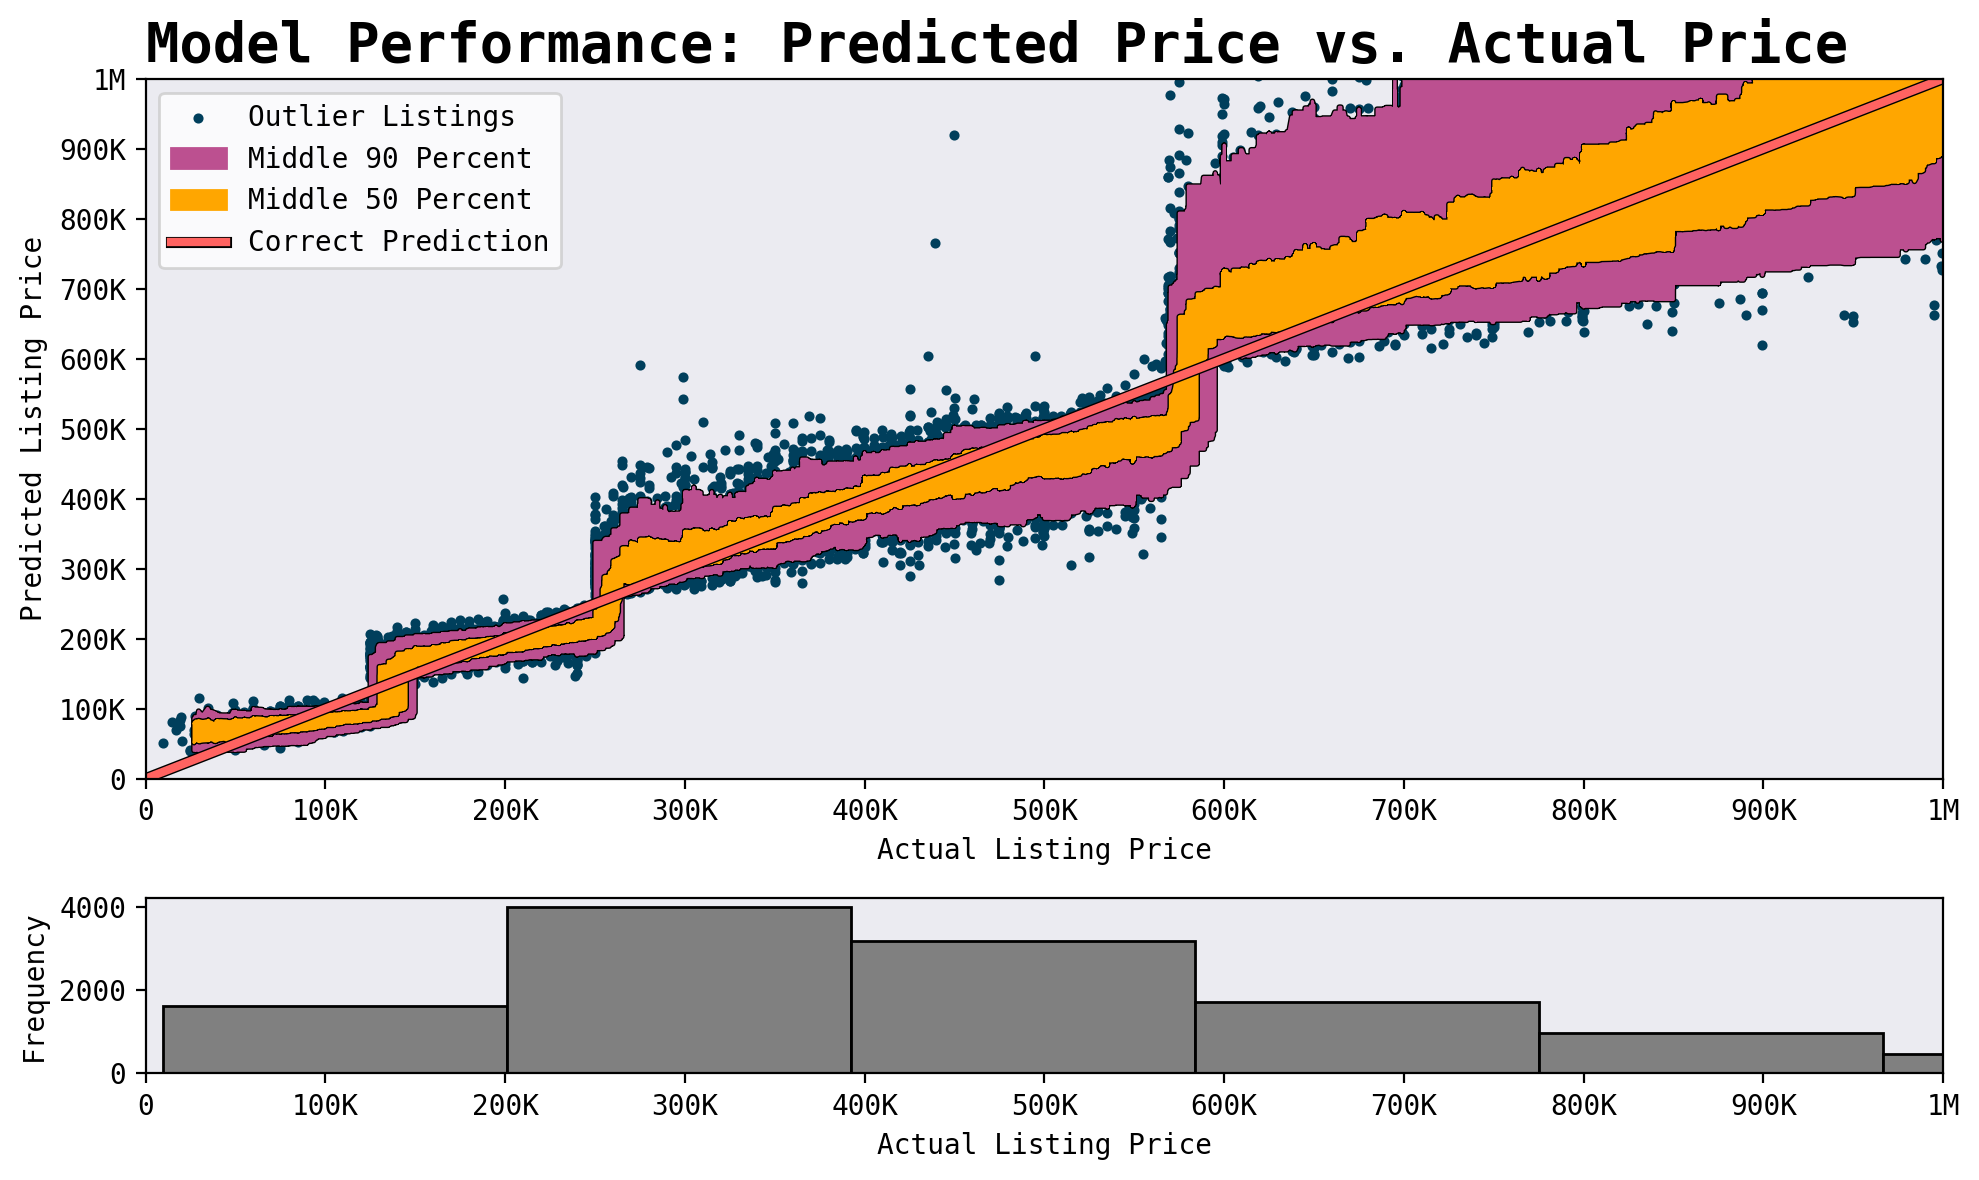

In [ ]:
# Plot errors.
plot_errors(y_test, y_pred)

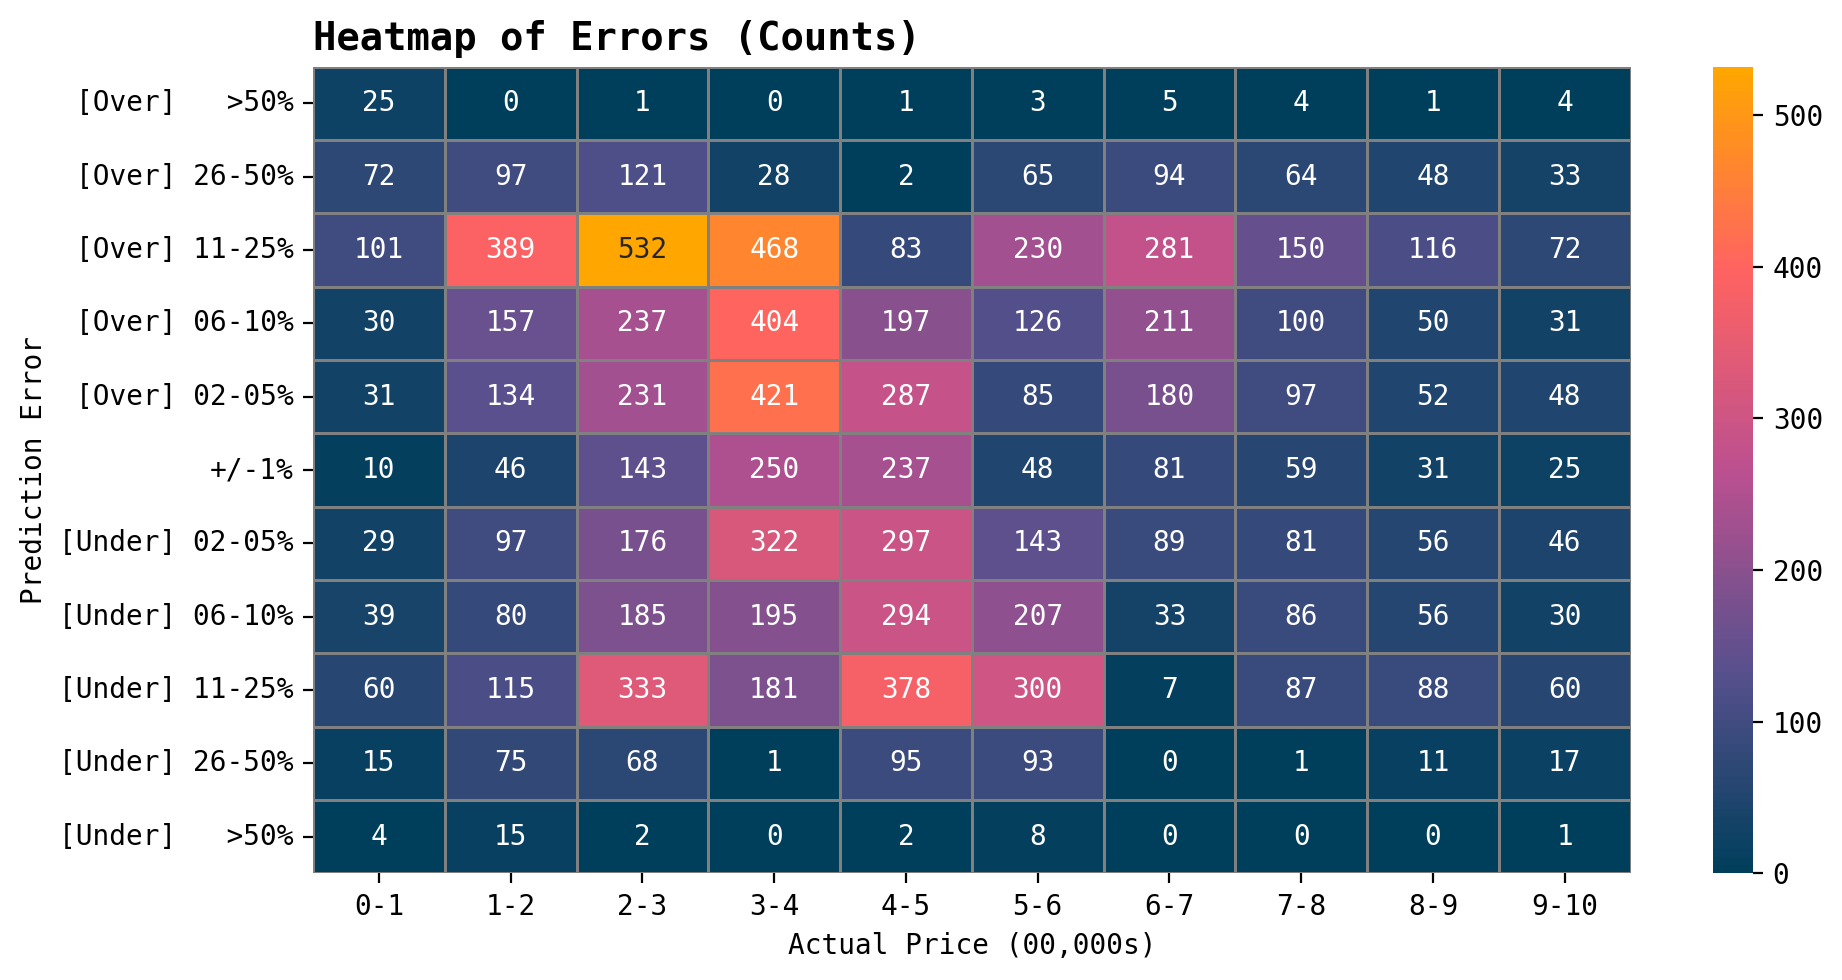

In [ ]:
# Plot heatmap.
plot_errors_heatmap(y_test, y_pred)

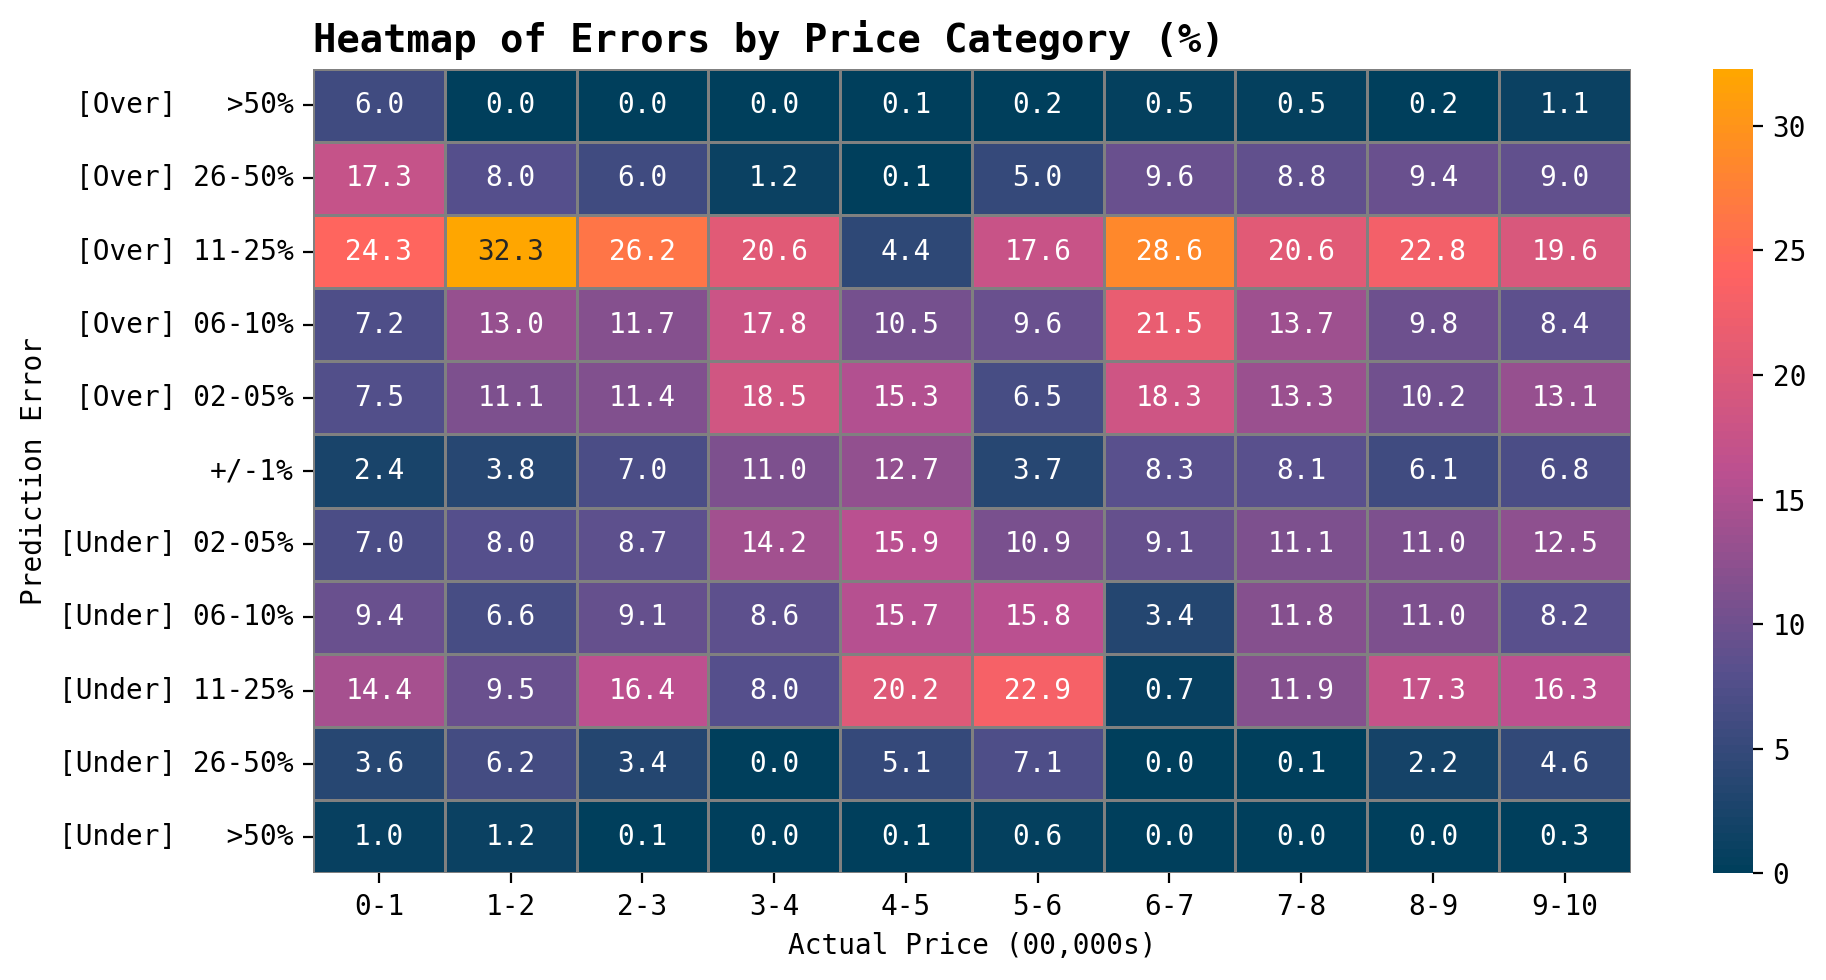

In [ ]:
# Plot heatmap (percentage).
plot_errors_heatmap(y_test, y_pred, pct=True)

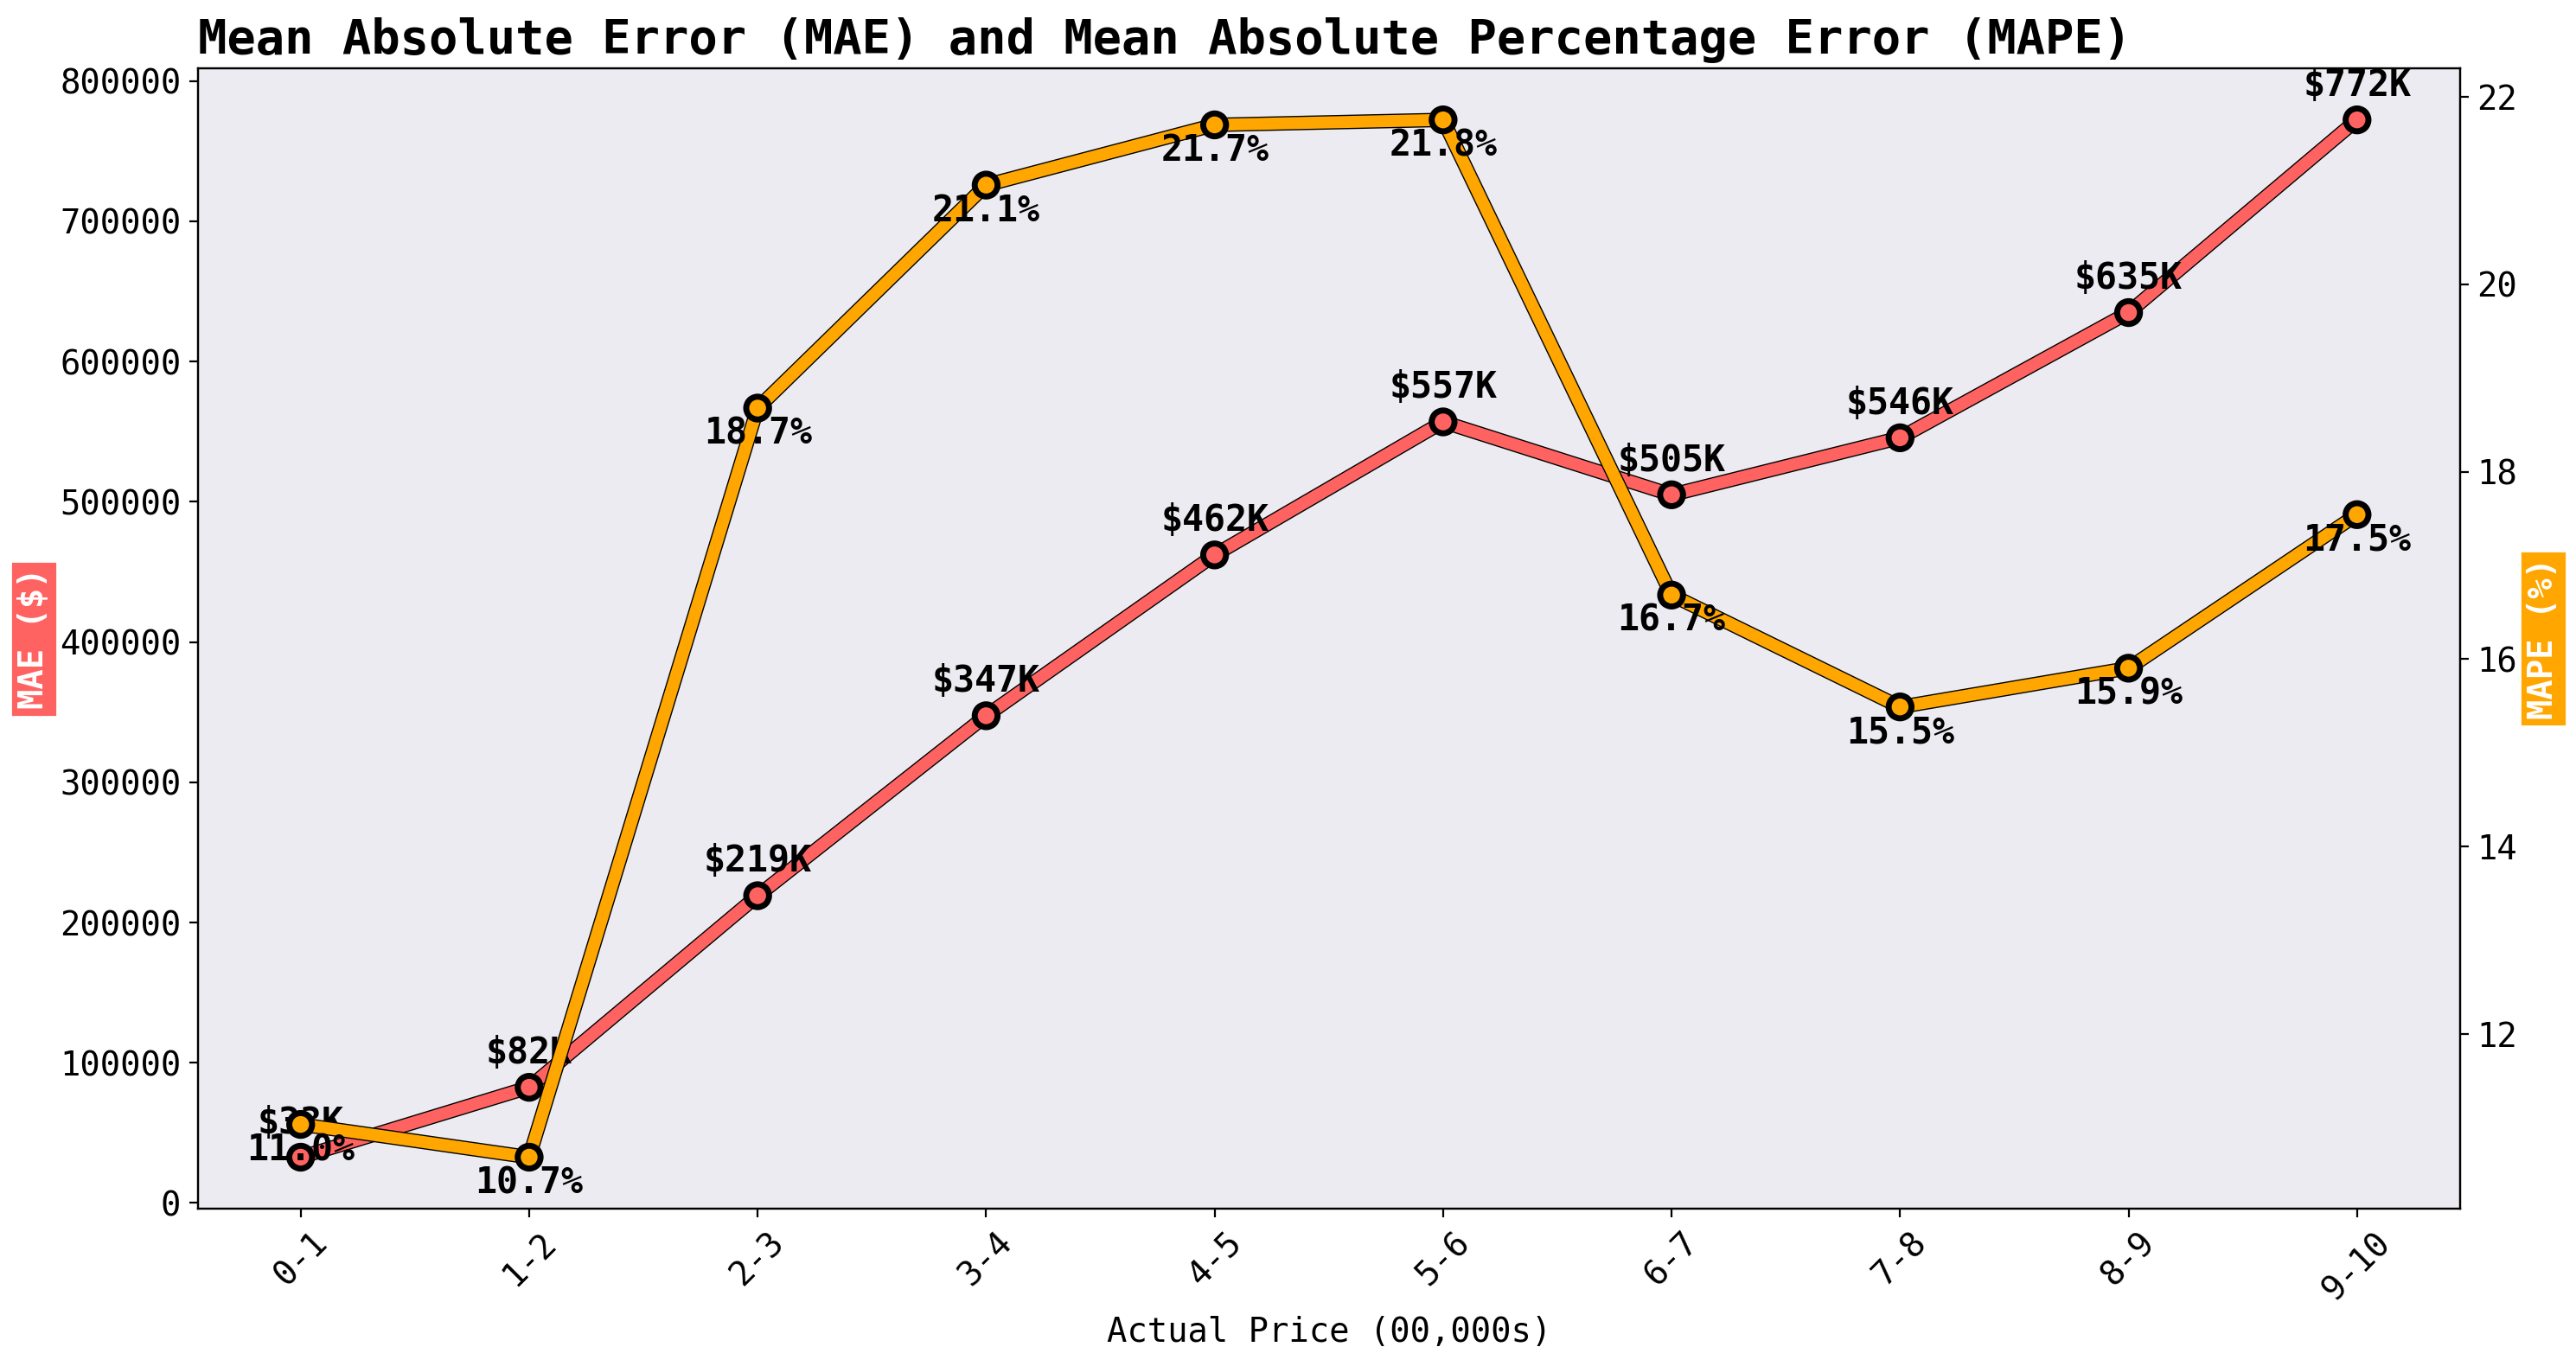

In [ ]:
# Plot mae / mape trade off.
plot_errors_mape_vs_mae(y_test, y_pred, bins=10)

In [ ]:
df_test = df[df['zillowId'].isin(y_test.reset_index()['zillowId'])]

# Add residuals and errors to the test DataFrame
df_test['Actual'] = y_test.values
df_test['Predicted'] = y_pred
df_test['Residual'] = df_test['Actual'] - df_test['Predicted']
df_test['Abs_Residual'] = np.abs(df_test['Residual'])
df_test['Percent_Error'] = (df_test['Abs_Residual'] / df_test['Actual']) * 100

# Failure Analysis Plots
def plot_failure_analysis(data, residual_col, error_col):
    fig, axes = plt.subplots(1, 3, figsize=(24, 8))  # 1 row, 3 columns

    # Residual Histogram
    sns.histplot(data[residual_col], kde=True, bins=50, color='blue', alpha=0.7, ax=axes[0])
    axes[0].set_title('Distribution of Residuals', fontsize=16)
    axes[0].set_xlabel('Residual', fontsize=14)
    axes[0].set_ylabel('Frequency', fontsize=14)
    axes[0].grid()

    # Percent Error vs Actual Prices
    sns.scatterplot(x=data['Actual'], y=data[error_col], alpha=0.5, ax=axes[1])
    axes[1].set_title('Percent Error vs. Actual Prices', fontsize=16)
    axes[1].set_xlabel('Actual Prices', fontsize=14)
    axes[1].set_ylabel('Percent Error (%)', fontsize=14)
    axes[1].grid()

    # Residuals vs Predicted Prices
    sns.scatterplot(x=data['Predicted'], y=data[residual_col], alpha=0.5, ax=axes[2])
    axes[2].axhline(0, color='red', linestyle='--', linewidth=2)
    axes[2].set_title('Residuals vs. Predicted Prices', fontsize=16)
    axes[2].set_xlabel('Predicted Prices', fontsize=14)
    axes[2].set_ylabel('Residuals', fontsize=14)
    axes[2].grid()

    # Adjust layout
    plt.tight_layout()
    plt.show()

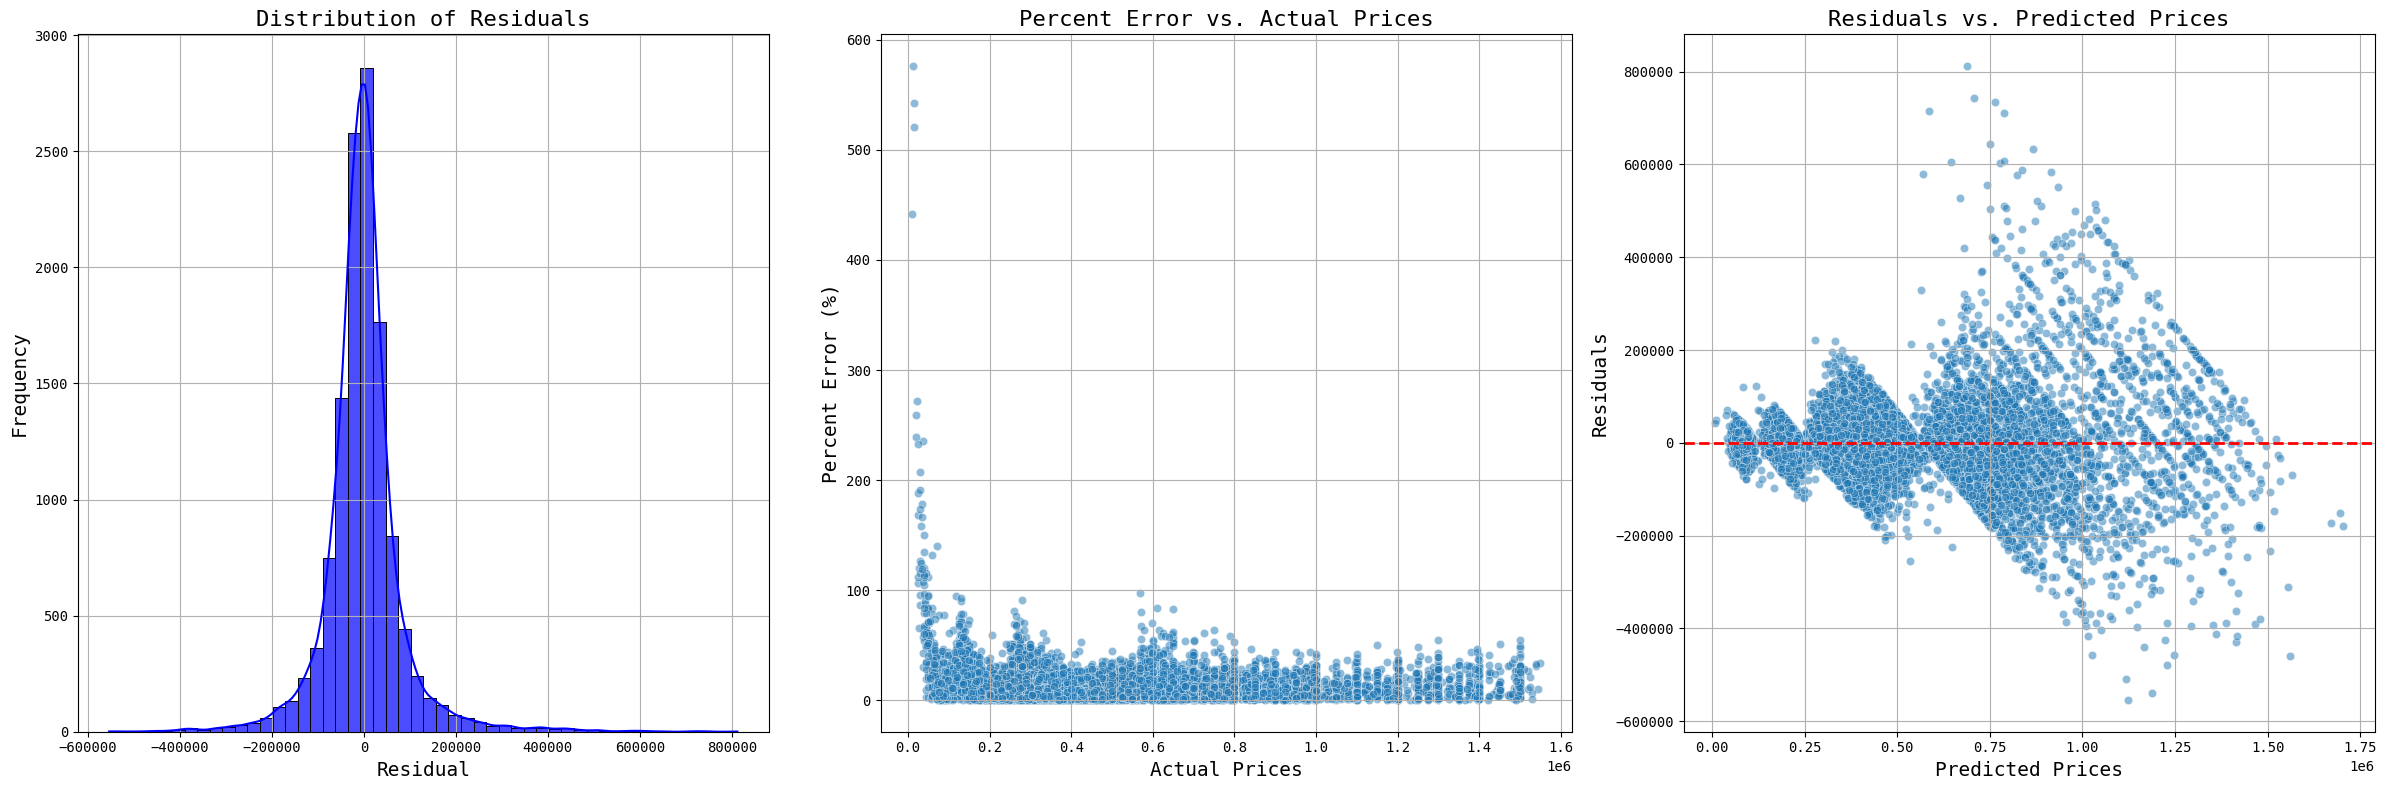

In [ ]:
# Call the updated plotting function
plot_failure_analysis(df_test, residual_col='Residual', error_col='Percent_Error')

In [ ]:
# Analyze Outliers
outlier_threshold = 10  # Define a percent error threshold
outliers = df_test[df_test['Percent_Error'] > outlier_threshold]

# Outliers Summary
print(f"\nNumber of Outliers (Percent Error > {outlier_threshold}%): {len(outliers)}")
print(outliers[['Actual', 'Predicted', 'Residual', 'Percent_Error']].head())


Number of Outliers (Percent Error > 10%): 5504
       Actual     Predicted       Residual  Percent_Error
9    210000.0  1.865477e+05   23452.328125      11.167775
16  1275000.0  1.098519e+06  176480.750000      13.841627
71   370000.0  4.242225e+05  -54222.500000      14.654730
73   269000.0  3.584945e+05  -89494.531250      33.269342
74  1030000.0  9.107016e+05  119298.437500      11.582373


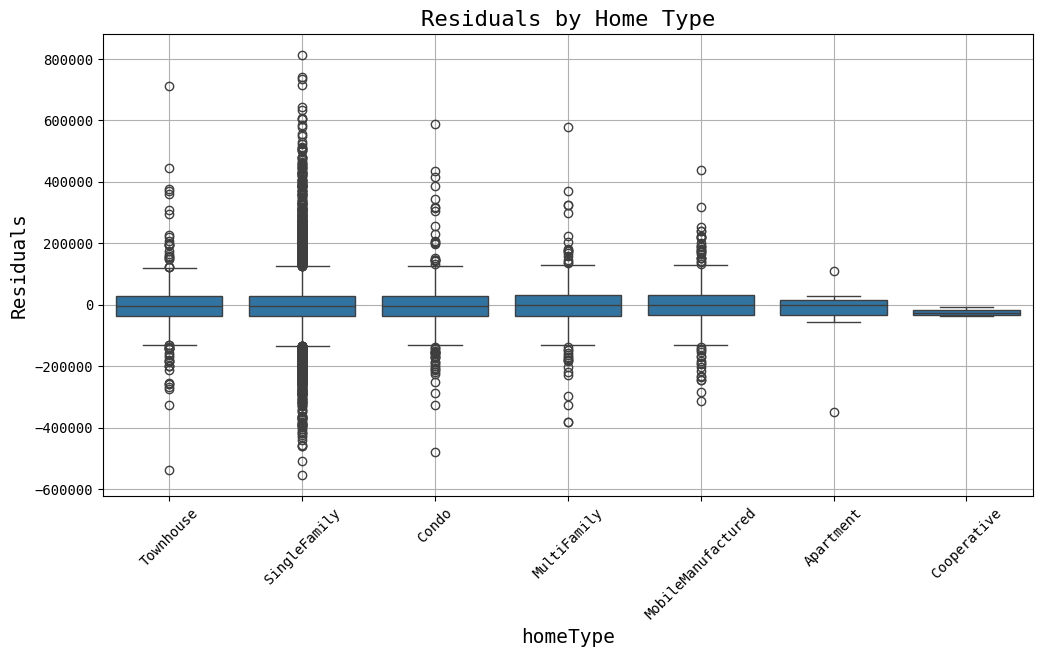

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='homeType', y='Residual', data=df_test)
plt.title('Residuals by Home Type', fontsize=16)
plt.xlabel('homeType', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.xticks(rotation=45)  # Rotate labels for readability
plt.grid(True)
plt.show()

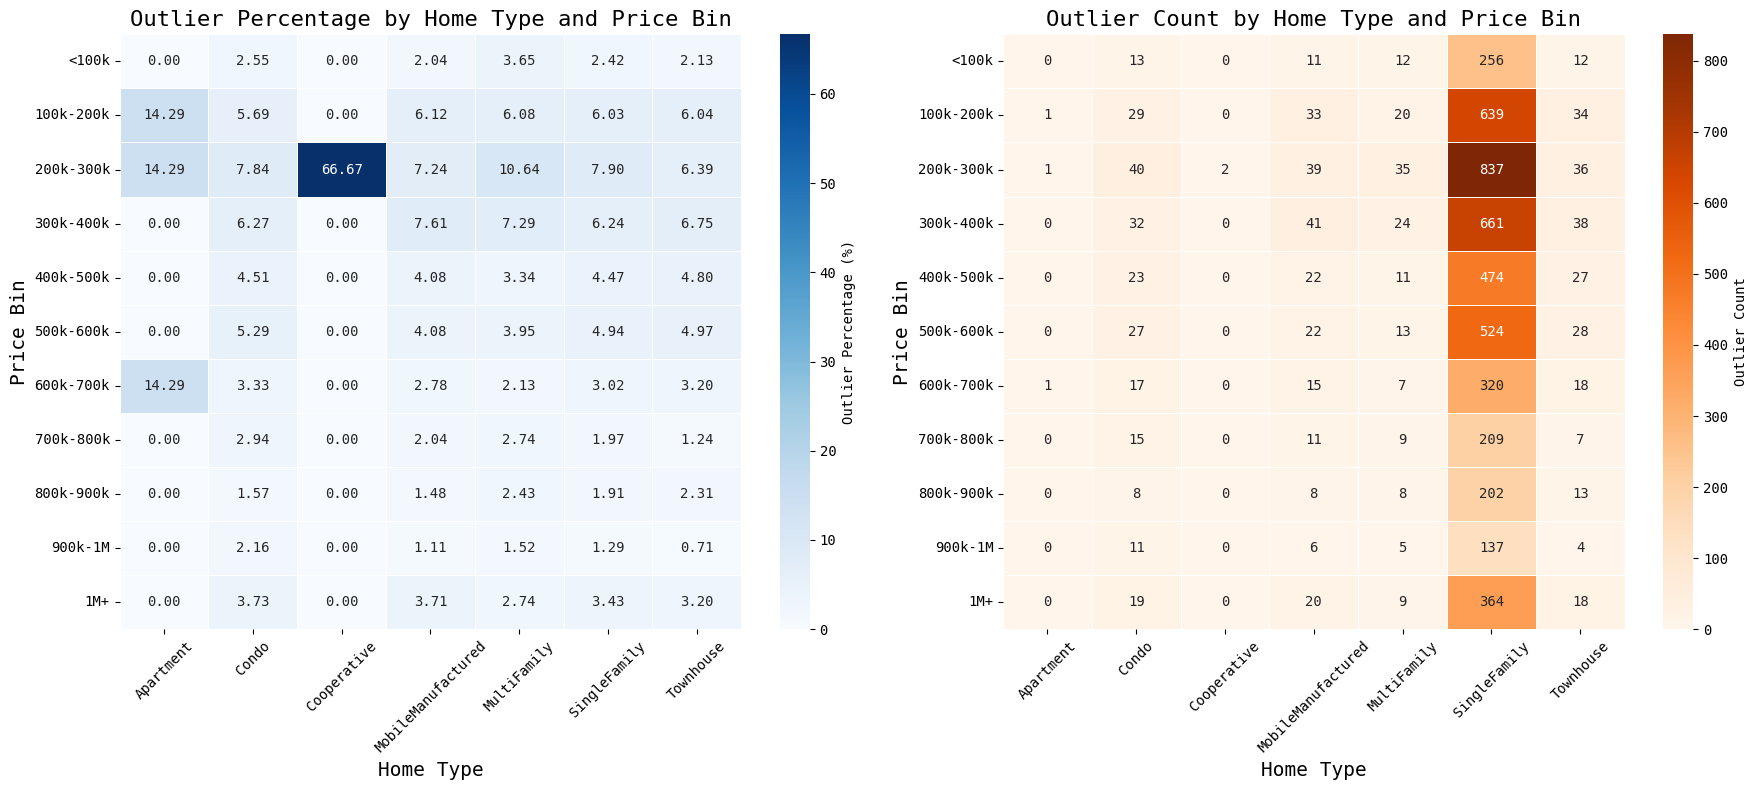

In [ ]:
# 1. Bin the actual prices into specified intervals
price_bins = [0, 100000, 200000, 300000, 400000, 500000, 600000, 700000, 800000, 900000, 1000000, 1500000]
price_labels = ['<100k', '100k-200k', '200k-300k', '300k-400k', '400k-500k', '500k-600k', '600k-700k', '700k-800k',
                '800k-900k', '900k-1M', '1M+']

df_test['Price_Bin'] = pd.cut(df_test['Actual'], bins=price_bins, labels=price_labels, right=False)

# 2. Identify outliers based on the percent error threshold
outliers = df_test[df_test['Percent_Error'] > outlier_threshold]

# 3. Create a pivot table to count outliers per homeType and price bin
outlier_counts = pd.crosstab(outliers['Price_Bin'], outliers['homeType'])

# 4. Calculate the total count of each homeType
total_counts = df_test.groupby('homeType').size()

# 5. Calculate the percentage of outliers for each homeType and price bin
outlier_percentages = outlier_counts.div(total_counts, axis=1) * 100

# 6. Plot both heatmaps (percentage and actual count) in a single figure
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Left heatmap: Percentages
sns.heatmap(outlier_percentages, annot=True, fmt='.2f', cmap='Blues', cbar_kws={'label': 'Outlier Percentage (%)'},
            linewidths=0.5, ax=axes[0])
axes[0].set_title(f'Outlier Percentage by Home Type and Price Bin', fontsize=16)
axes[0].set_xlabel('Home Type', fontsize=14)
axes[0].set_ylabel('Price Bin', fontsize=14)
axes[0].tick_params(axis='x', rotation=45)
axes[0].tick_params(axis='y', rotation=0)

# Right heatmap: Actual counts
sns.heatmap(outlier_counts, annot=True, fmt='d', cmap='Oranges', cbar_kws={'label': 'Outlier Count'},
            linewidths=0.5, ax=axes[1])
axes[1].set_title(f'Outlier Count by Home Type and Price Bin', fontsize=16)
axes[1].set_xlabel('Home Type', fontsize=14)
axes[1].set_ylabel('Price Bin', fontsize=14)
axes[1].tick_params(axis='x', rotation=45)
axes[1].tick_params(axis='y', rotation=0)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [ ]:
# Evaluate the algorithms, save the results.
single_family_results = evaluate_algorithms(df[df['homeType'] == 'SingleFamily'], featureSet3, algorithms,filename=None)
single_family_results.to_csv('single_family_results.csv')

 80%|████████  | 4/5 [02:34<00:43, 43.69s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047730 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13743
[LightGBM] [Info] Number of data points in the train set: 41394, number of used features: 96
[LightGBM] [Info] Start training from score 479455.275837


100%|██████████| 5/5 [02:38<00:00, 31.64s/it]


In [ ]:
# Visualize results.
single_family_results[['model','rmse','r2','mae','mape']].sort_values(by='r2',ascending=False)

model           rmse        r2           mae      mape
3          XGB Regressor   74536.942696  0.917755  48431.416382  0.109559
2  Extra Trees Regressor   75077.744060  0.916557  48417.613303  0.108587
4         LGBM Regressor   75463.288992  0.915698  50603.741467  0.116558
0      Linear Regression  111034.482099  0.817493  78829.621509  0.206270
1             ElasticNet  117020.995236  0.797282  80986.099146  0.209702

In [ ]:
# Evaluate the algorithms, save the results.
v5_results = evaluate_algorithms(df, featureSet3, algorithms,filename=None)
v5_results.to_csv('v5_results.csv')

 80%|████████  | 4/5 [03:15<00:54, 54.42s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028198 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13861
[LightGBM] [Info] Number of data points in the train set: 50199, number of used features: 103
[LightGBM] [Info] Start training from score 497739.675372


100%|██████████| 5/5 [03:19<00:00, 39.90s/it]


In [ ]:
# Visualize results.
v5_results[['model','rmse','r2','mae','mape']].sort_values(by='r2',ascending=False)

model           rmse        r2           mae      mape
3          XGB Regressor   86300.506262  0.916028  53960.187730  0.119947
2  Extra Trees Regressor   87976.129017  0.912736  54020.732588  0.116863
4         LGBM Regressor   88406.211283  0.911880  56769.504695  0.128971
0      Linear Regression  132605.960357  0.801741  90404.958725  0.234612
1             ElasticNet  140446.139555  0.777604  93946.155914  0.244869

In [ ]:
# Unpack y_test / y_pred values from winning model.
y_test = pickle.loads(v5_results[v5_results['model']=='XGB Regressor']['y_test'].values[0])
y_pred = pickle.loads(v5_results[v5_results['model']=='XGB Regressor']['y_pred'].values[0])

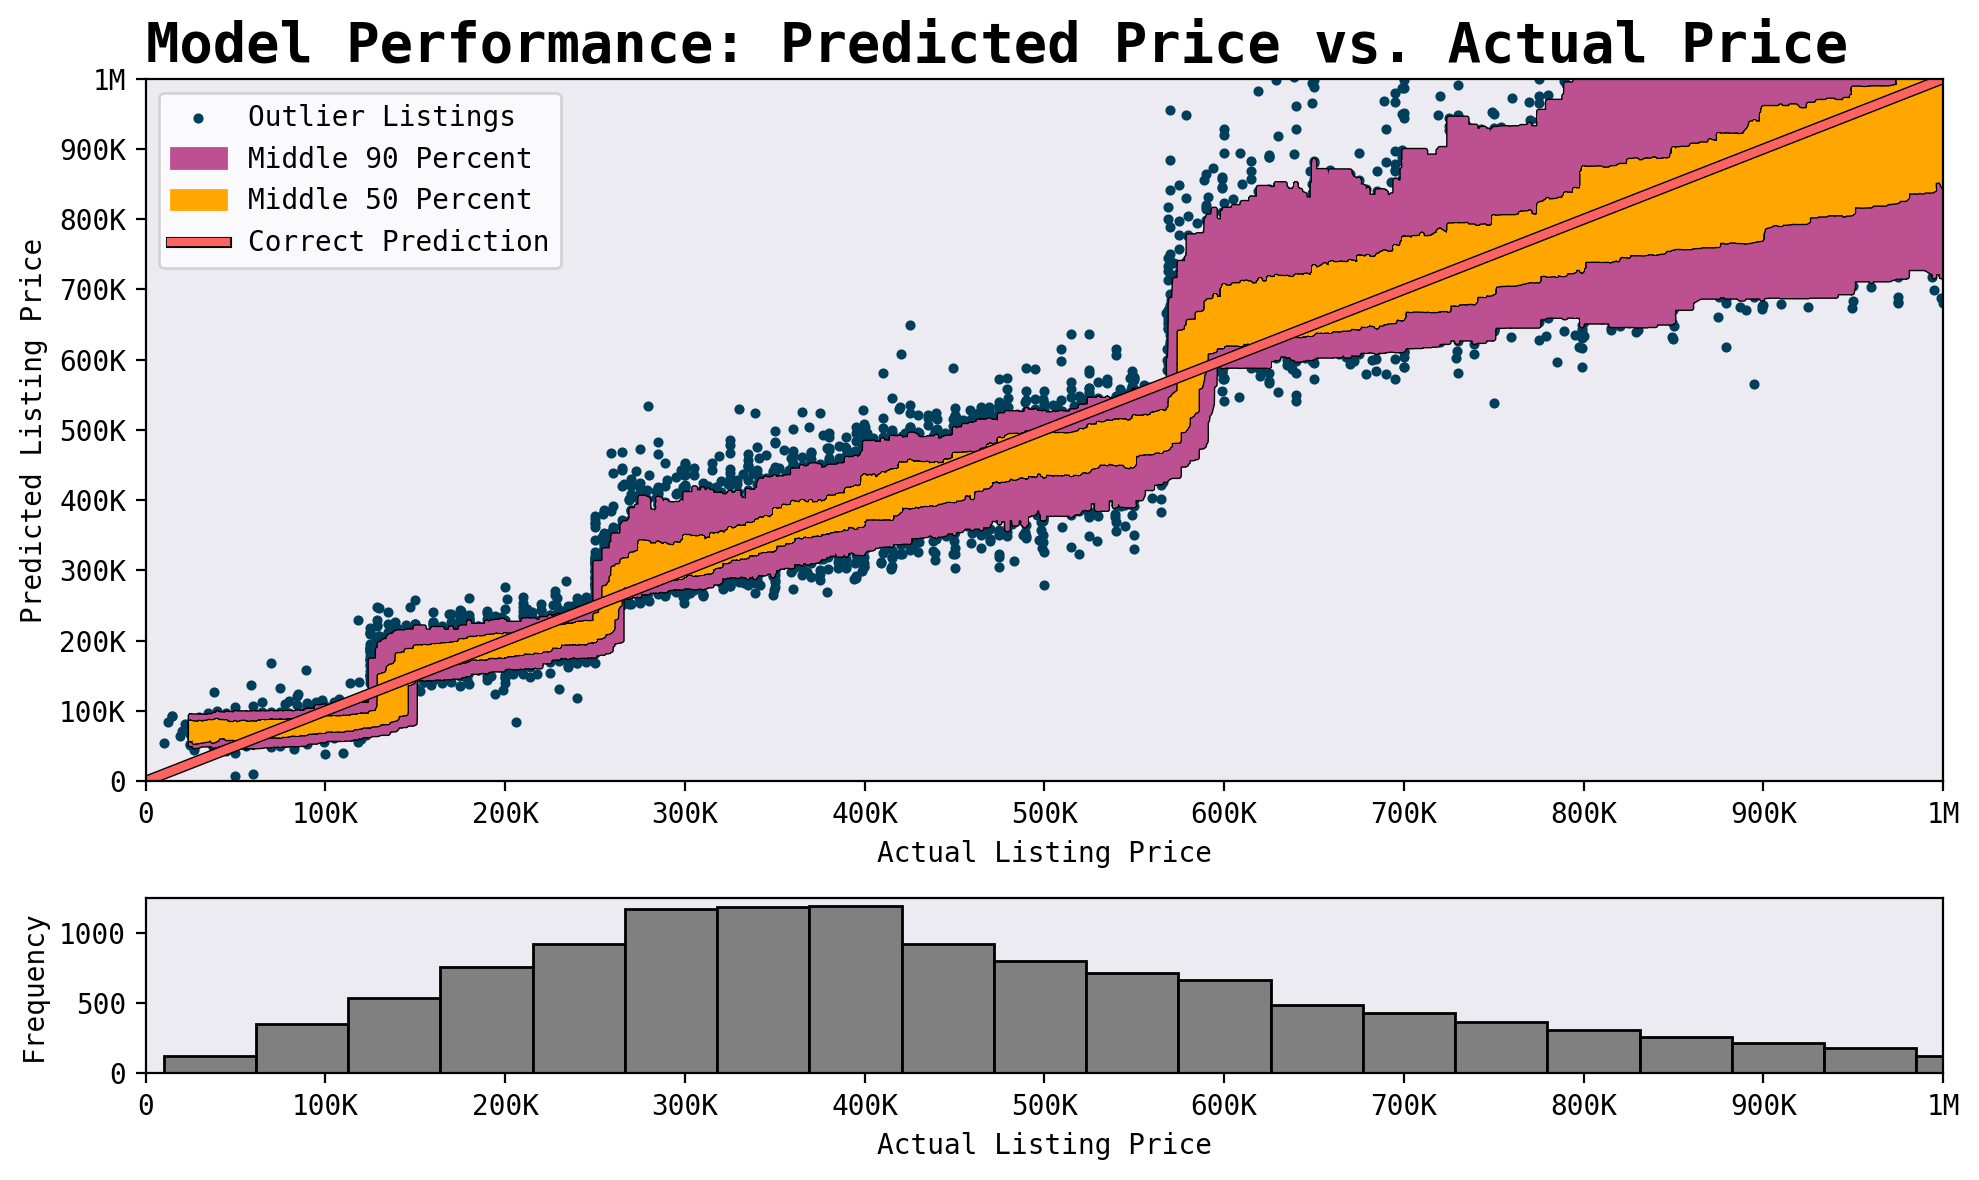

In [ ]:
# Plot errors.
plot_errors(y_test, y_pred)

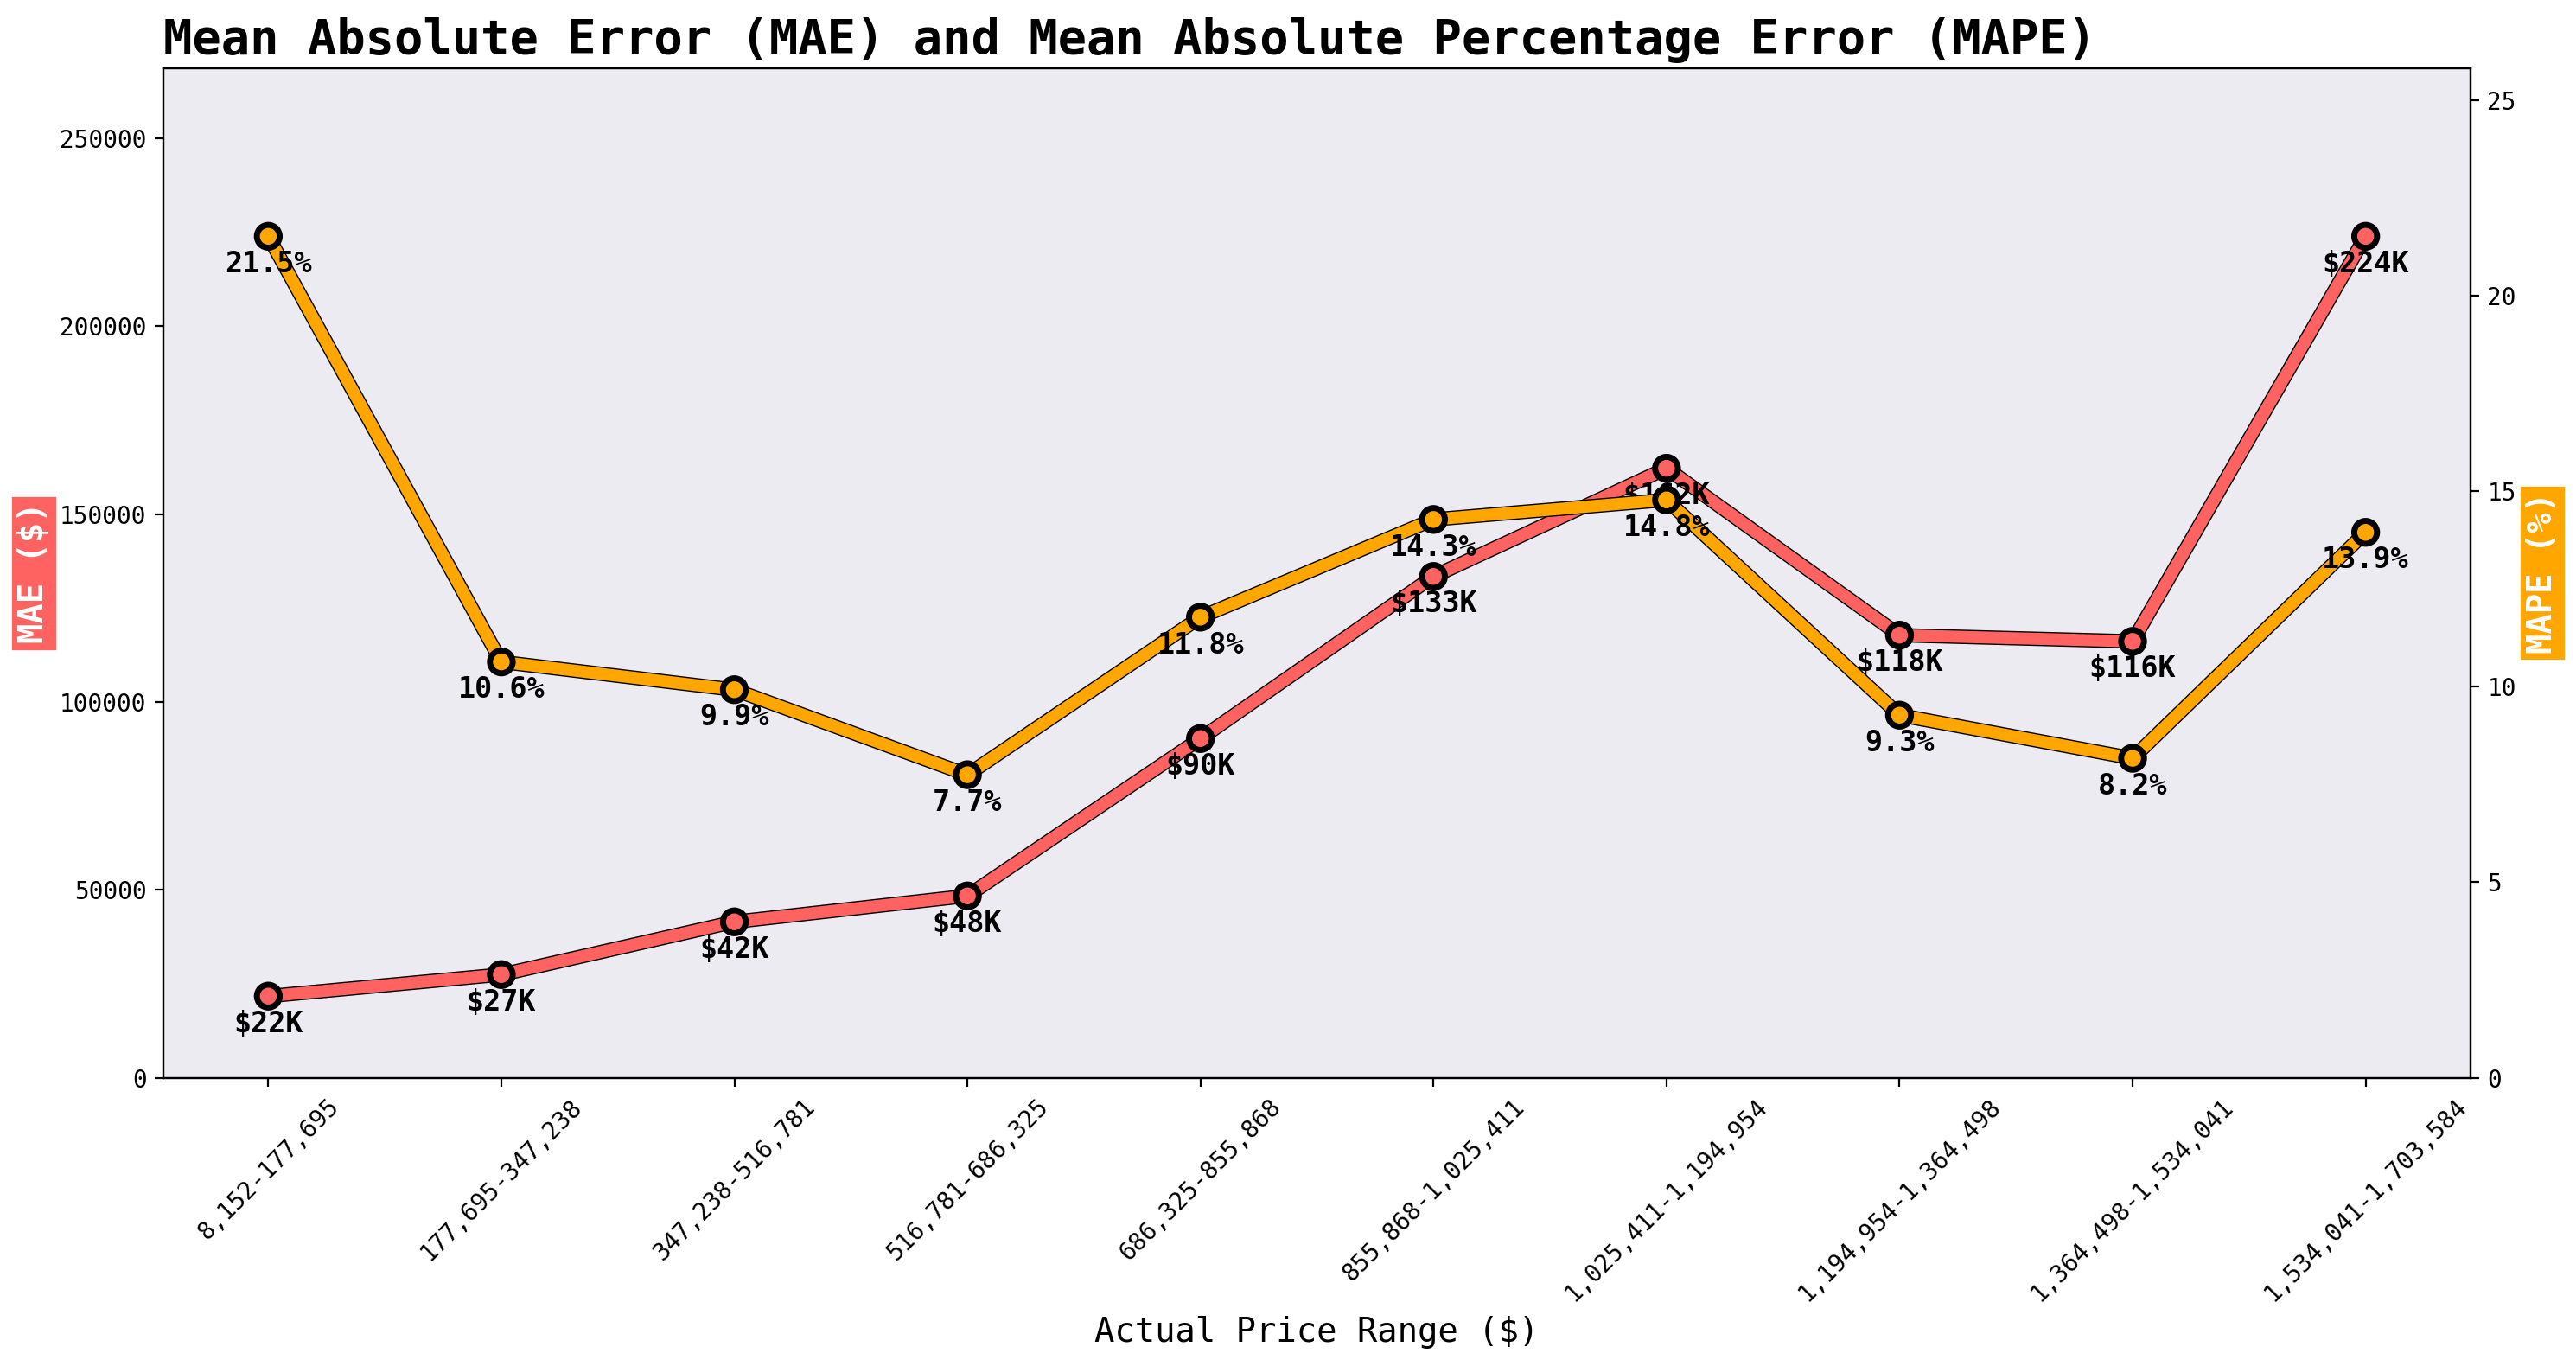

In [ ]:
# Plot mae / mape trade off.
plot_errors_mape_vs_mae(y_test, y_pred, bins=10)

In [ ]:
# Evaluate the algorithms, save the results.
excl_multi_results = evaluate_algorithms(df[df['homeType'] != 'MultiFamily'], featureSet3, algorithms,filename=None)
excl_multi_results.to_csv('excl_multi_results.csv')

 80%|████████  | 4/5 [03:26<00:57, 57.66s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.140036 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13795
[LightGBM] [Info] Number of data points in the train set: 48502, number of used features: 102
[LightGBM] [Info] Start training from score 486819.316379


100%|██████████| 5/5 [03:32<00:00, 42.56s/it]


In [ ]:
# Visualize results.
excl_multi_results[['model','rmse','r2','mae','mape']].sort_values(by='r2',ascending=False)

model           rmse        r2           mae      mape
3          XGB Regressor   83445.924956  0.914045  52994.385339  0.117613
2  Extra Trees Regressor   84010.452207  0.912878  52464.698148  0.114704
4         LGBM Regressor   84508.176767  0.911842  55290.990648  0.126127
0      Linear Regression  127374.862705  0.799724  87665.293502  0.228094
1             ElasticNet  133418.065617  0.780269  89838.982504  0.230780

### Time to add in image data